In [1]:
#To run this notebook :
#conda create -n brms r-rstan r-brms

#$ conda create -n brms r-rstan r-brms notebook
#$ conda activate brms
#$ R 
#> remove.packages(c("StanHeaders", "rstan")) #solution from https://discourse.mc-stan.org/t/error-s-during-compilation-with-rstan-in-hpc/21948/3

#># Compile packages using all cores 
#>Sys.setenv(MAKEFLAGS = paste0("-j",parallel::detectCores()))

#>install.packages(c("StanHeaders","rstan"),type="source")
#>install.packages("devtools")
#>devtools::install_github("IRkernel/IRkernel")
#>IRkernel::installspec()
#>q()
#$ conda install rise

In [1]:
library(repr)

options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size


# Linear Mixed Models : application to data in cognitive science

## Module 3 : Bayes and Generalized LMM


 &nbsp;
 &nbsp;
 &nbsp;

 <center> Gabriel Weindel, PhD, April 2021 at AMU </center>


This last module is intended to give you an intuition of Bayesian estimation of LMMs as well as the generalization of what we learned of LMMs to non-normal target distributions : generalized LMMs

1. Bayes, why and how ?
2. Linear models and Bayesian estimation
3. LMMs and Bayesian estimation
4. Leaving the normal world - GLM(M)s

# Why Bayes ?

- When you read a confidence interval (CI) does it state the probability of the true value being contained in the CI interval ?

__No__ ! 

In [2]:
n_rep = 100 #100 tests repeated
matrix_ci_values = NULL
for (i in 1:n_rep){
    grp1 = rnorm(10, 0, 1)
    grp2 = rnorm(10, -1, 1)#H1 is true
    matrix_ci_values <- rbind(matrix_ci_values,matrix(c(t.test(grp1,grp2)$conf.int[1],t.test(grp1,grp2)$conf.int[2]), ncol=2,nrow=1) )
}
ci_corr = matrix_ci_values[(1 >= matrix_ci_values[,1]) & (1 <= matrix_ci_values[,2]),]#true included in CI
ci_incorr = matrix_ci_values[(1 >= matrix_ci_values[,2]) | (1 <= matrix_ci_values[,1]),]#true not included in CI

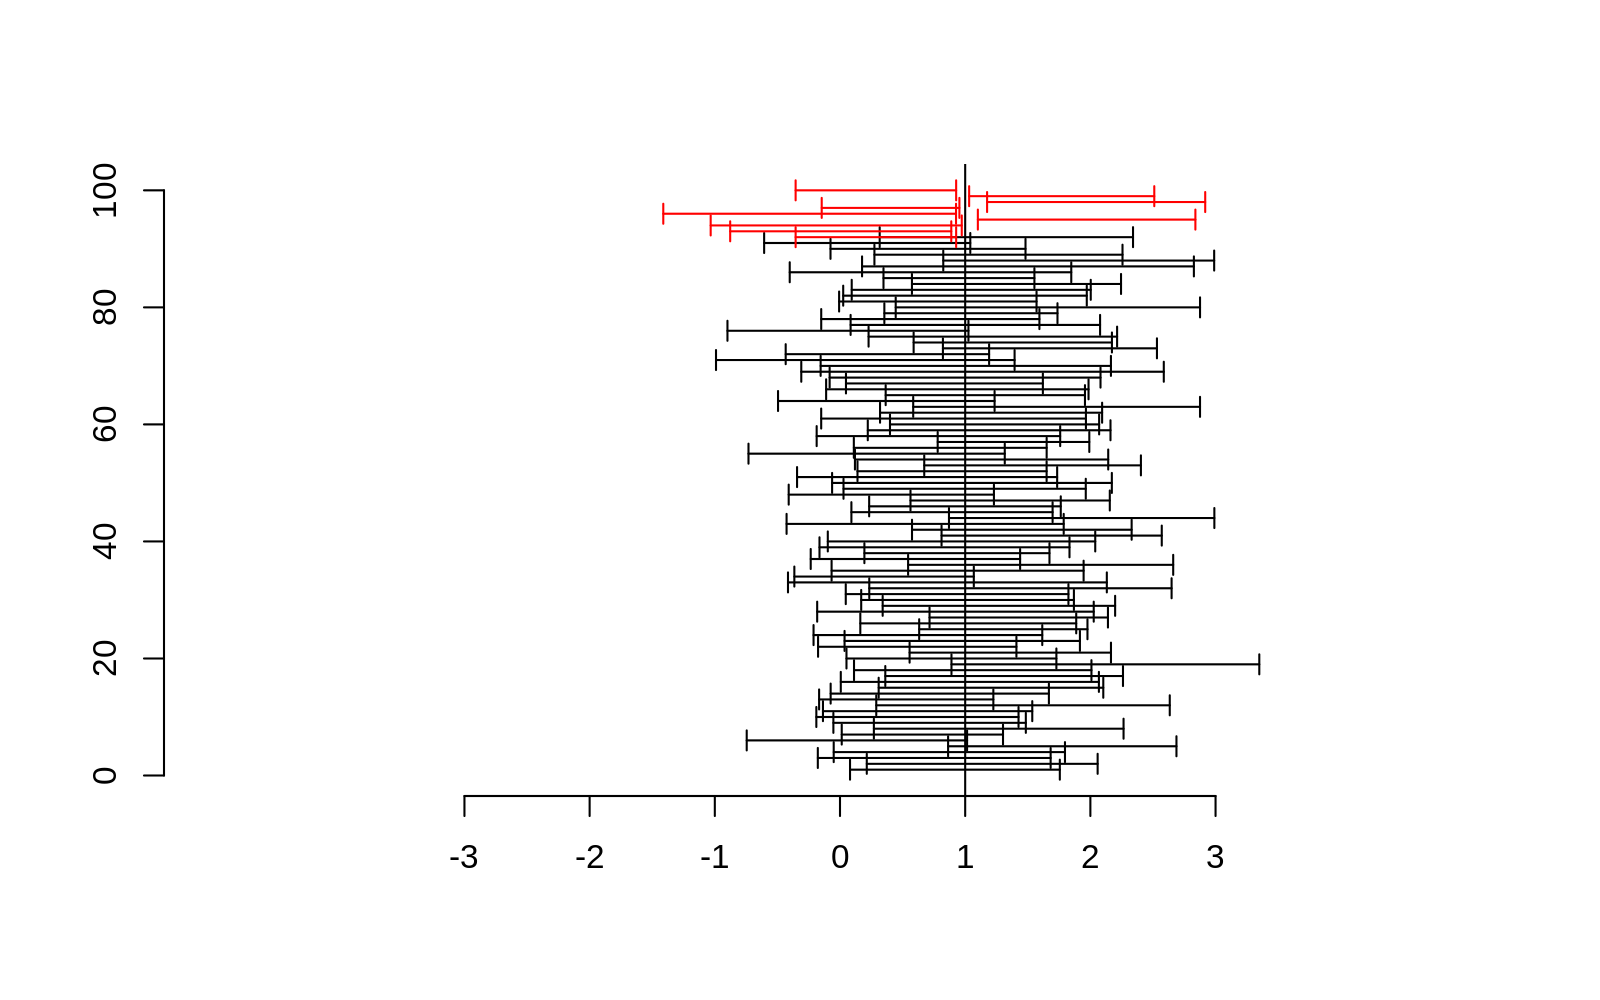

In [3]:
#Graphical  parameters
plot.new()
plot.window(xlim=c(-5,5), ylim=c(0.5, 100+.5), ylab="a")
axis(1, at=seq(-3, 3, by=1))
axis(2, at=seq(0, 100, by=20))

#Plotting correct CI vs incorrect
arrows(ci_corr[,1], 1:nrow(ci_corr), ci_corr[,2], 1:nrow(ci_corr), code=3, length=0.05, angle=90)
arrows(ci_incorr[,1], nrow(ci_corr):(nrow(ci_incorr)+nrow(ci_corr)), ci_incorr[,2],  
       nrow(ci_corr):(nrow(ci_incorr)+nrow(ci_corr)), code=3, length=0.05, angle=90,col="red")
#Plotting true effect as a line
abline(v=1)

95% of the CI contain true effect is the correct definition

Bayesian inference $= p(\theta|\text{Data,Model,Prior})$ _vs._ frequentist $= p(\text{Data}|\theta)$ (_e.g._ likelihood in module 2)

How do we go from $= p(\text{Data}|\theta)$ to $= p(\theta|\text{Data})$ ?

Bayes rule : 

\begin{equation}
\label{eq:bayes}
p(\theta|Data) = \frac{p(\theta ) p(Data |\theta)}{p(Data)}
\end{equation}

- $p(\theta | Data)$ = posterior
- $p(\theta)$ = prior belief
- $p(Data|\theta)$ = likelihood (see module 2)
- $p(Data)$ = "average likelihood" (standardizes the posterior)

Let's go back to our coin flip example of module 2 where $Data = 28$ heads of 40 flips: 

In [4]:
# Code adapted from R. McElreath's book (see ressources at the end of the module)
grid = 50
p_grid = seq(from=0, to=1, length.out = grid) #Discretizing the parameter space, aka grid approximation
prior = rep(1,grid)#Flat uninformative prior
likelihood = dbinom(28, size=40, prob=p_grid)
posterior = (likelihood*prior)/sum(likelihood*prior)



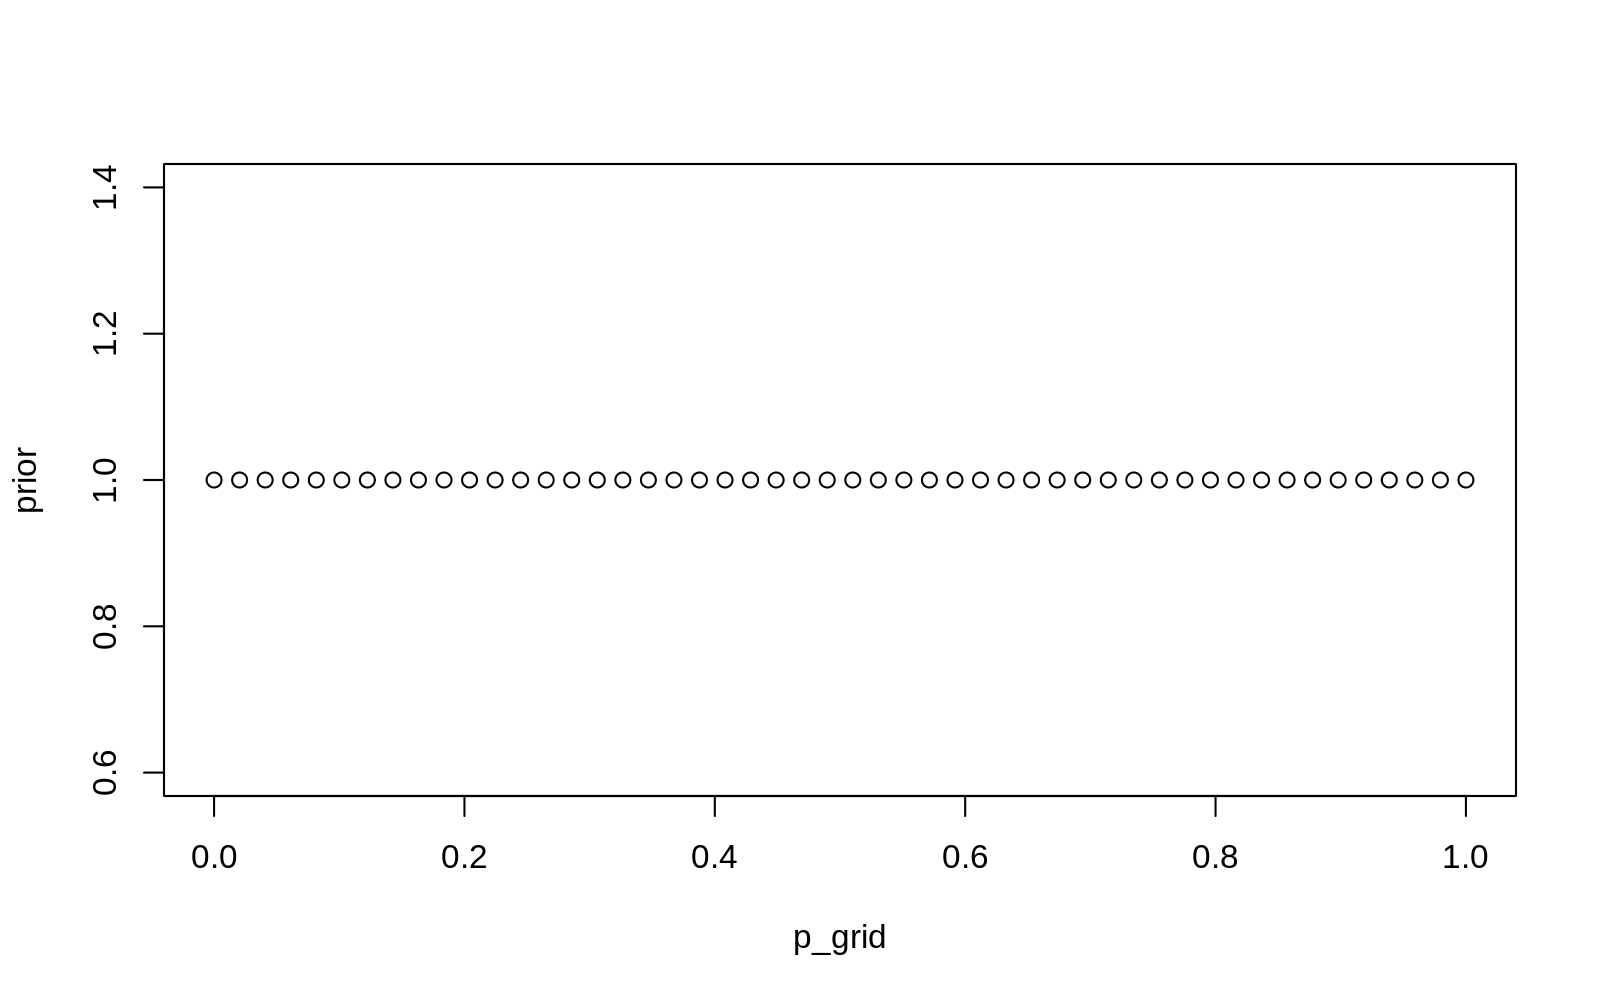

In [5]:
plot(p_grid, prior, type="b")

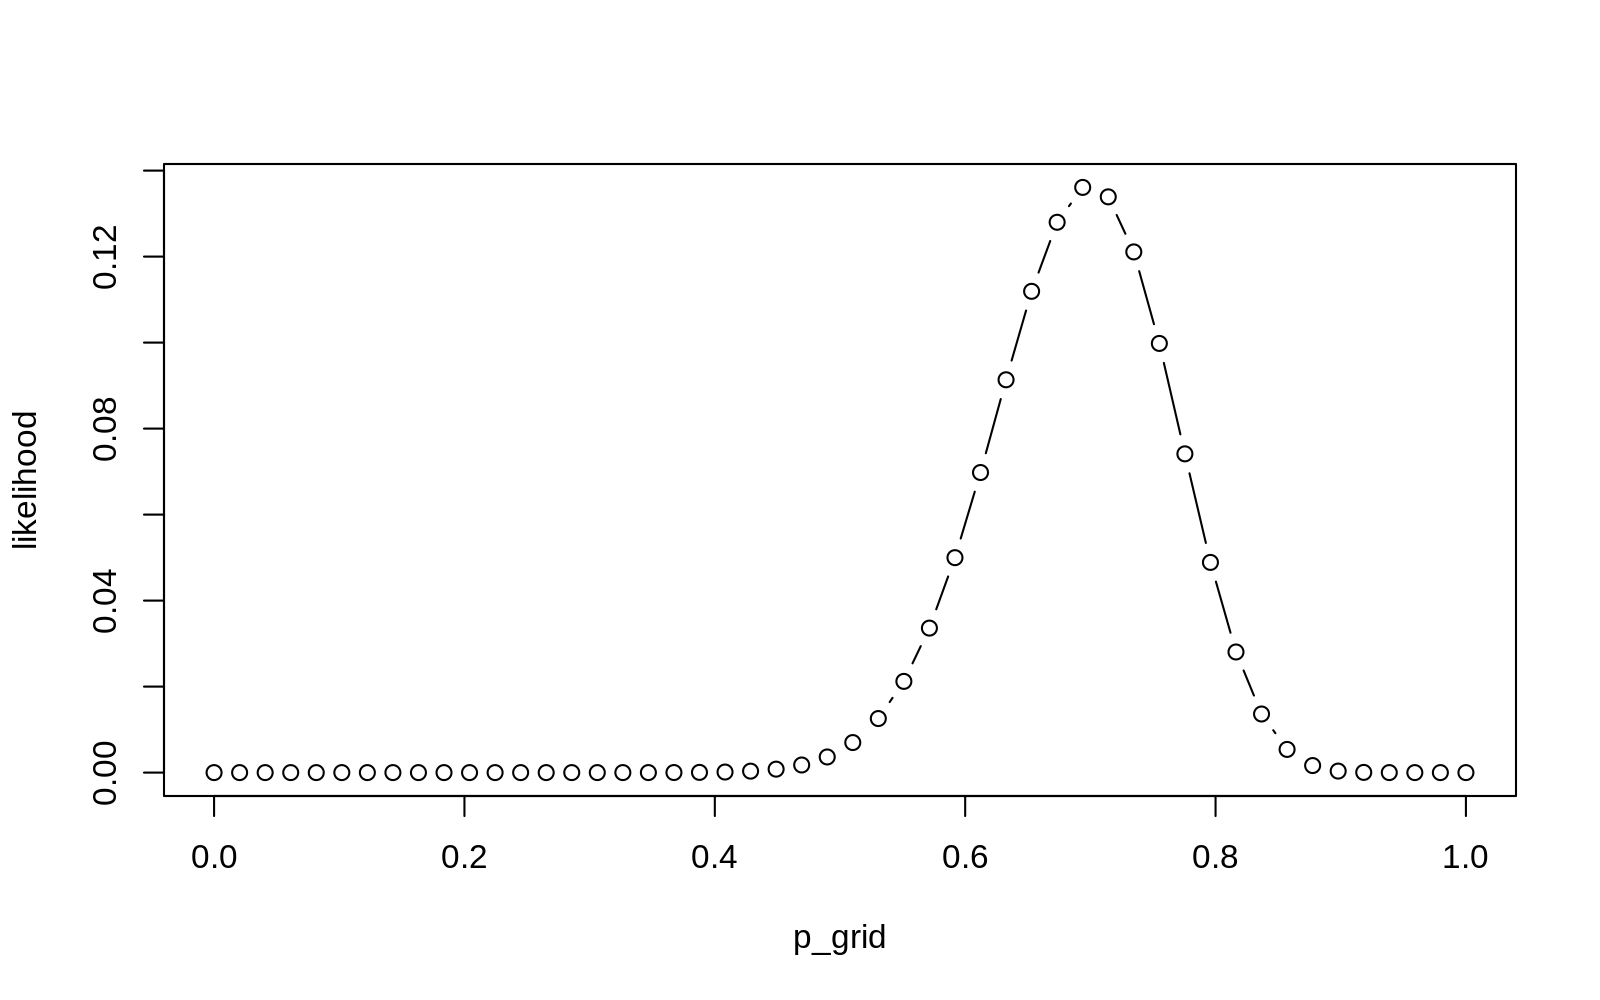

In [6]:
plot(p_grid, likelihood, type="b")

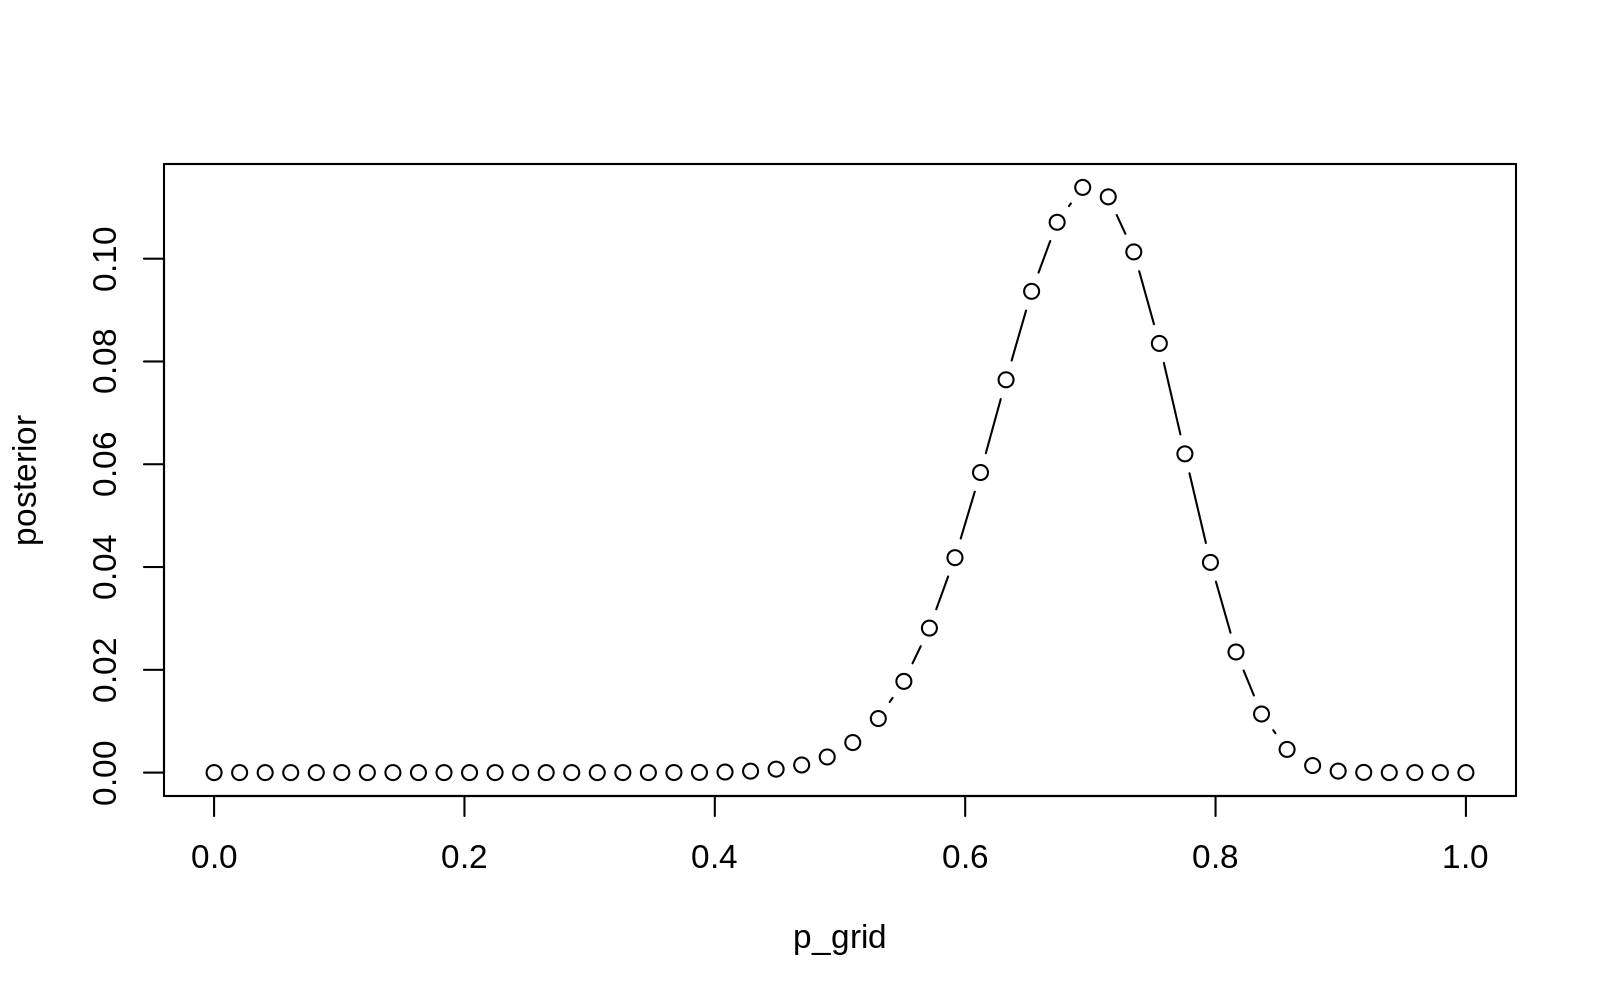

In [7]:
plot(p_grid, posterior, type="b")

Now we change the prior to illustrate the updating process from the observation of data on prior beliefs

In [8]:
# Code adapted from R. McElreath's book (see ressources at the end of the module)
grid = 50
p_grid = seq(from=0, to=1, length.out = grid)
prior = ifelse(p_grid <= .5, 0, 1)#informative prior we know coin is biased towards head, but agnostic on how much
likelihood = dbinom(28, size=40, prob=p_grid)
posterior = (likelihood*prior)/sum(likelihood*prior)



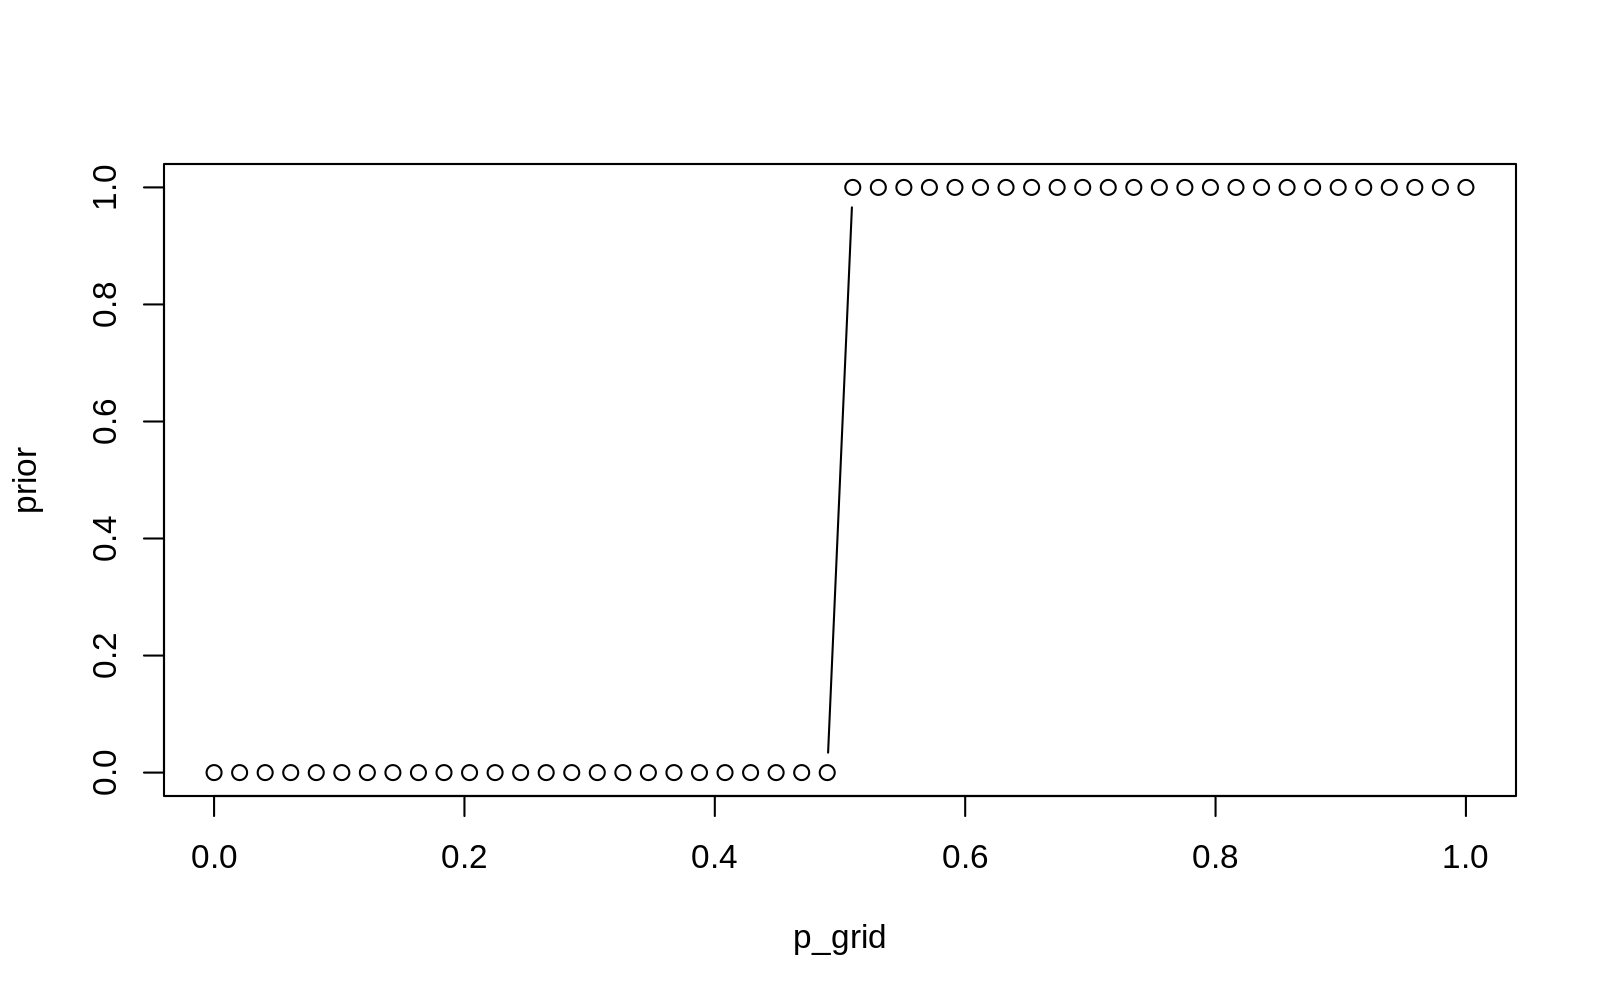

In [9]:
plot(p_grid, prior, type="b")

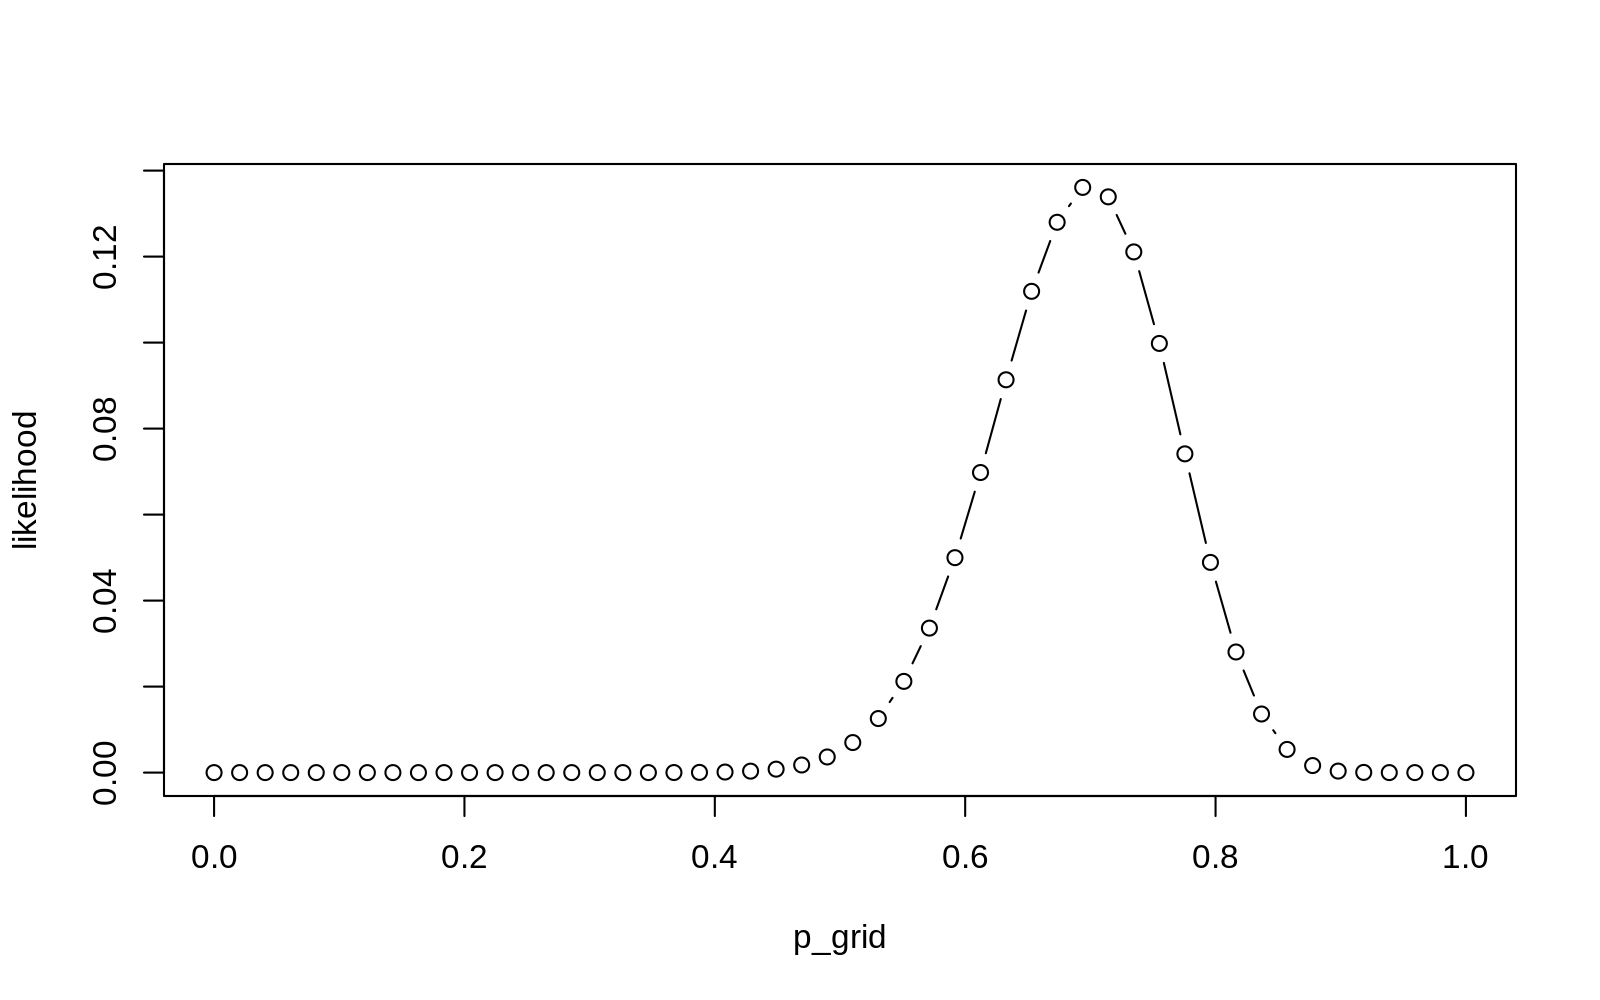

In [10]:
plot(p_grid, likelihood, type="b")

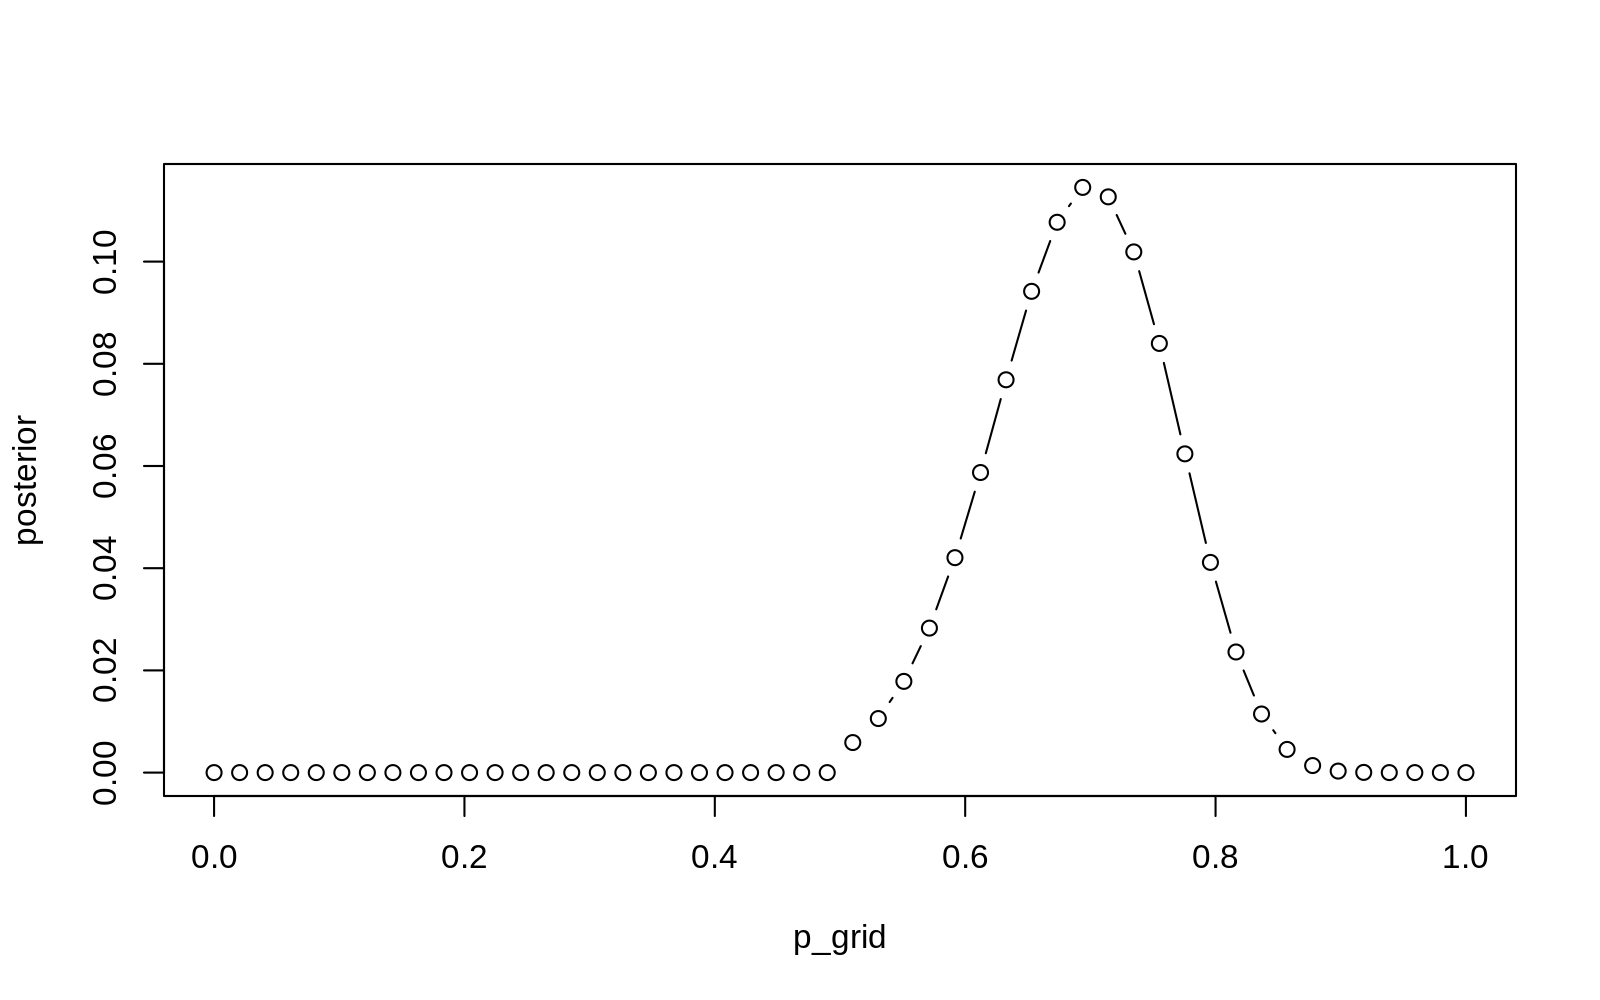

In [11]:
plot(p_grid, posterior, type="b")

In [12]:
# Code taken from R. McElreath's book (see ressources at the end of the module)
grid = 50
p_grid = seq(from=0, to=1, length.out = grid) #Discretizing the parameter space, aka grid approximation
prior = ifelse(p_grid > .5, 0, 1)#improper prior
likelihood = dbinom(28, size=40, prob=p_grid)
posterior = (likelihood*prior)/sum(likelihood*prior)

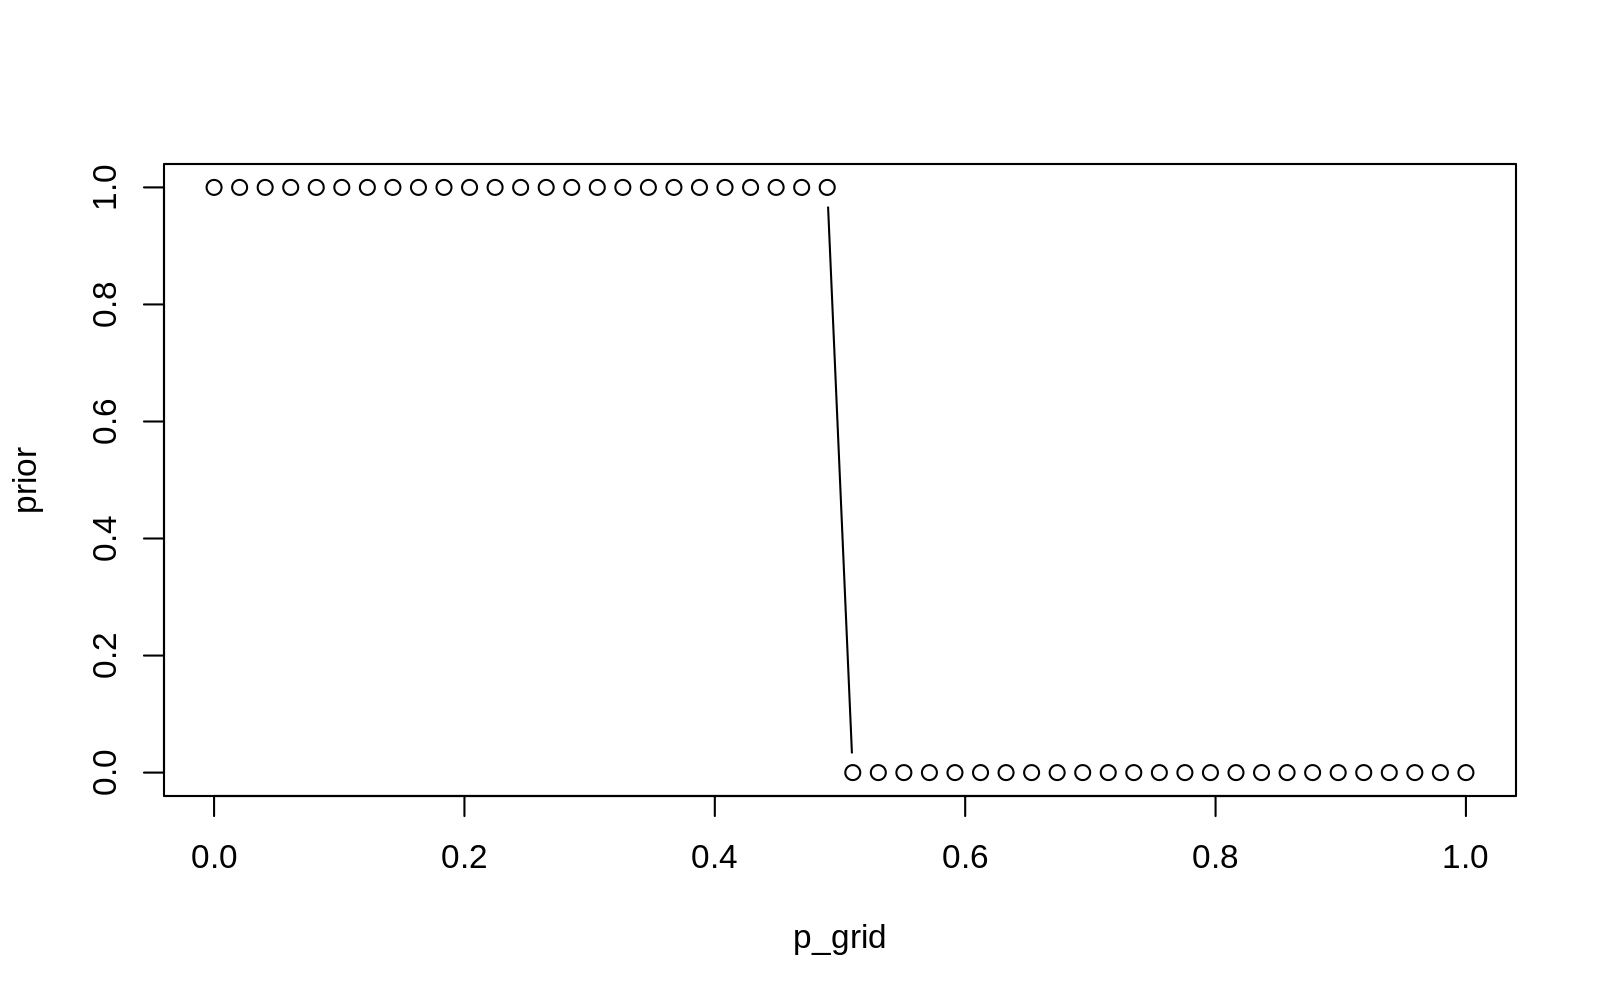

In [13]:
plot(p_grid, prior, type="b")

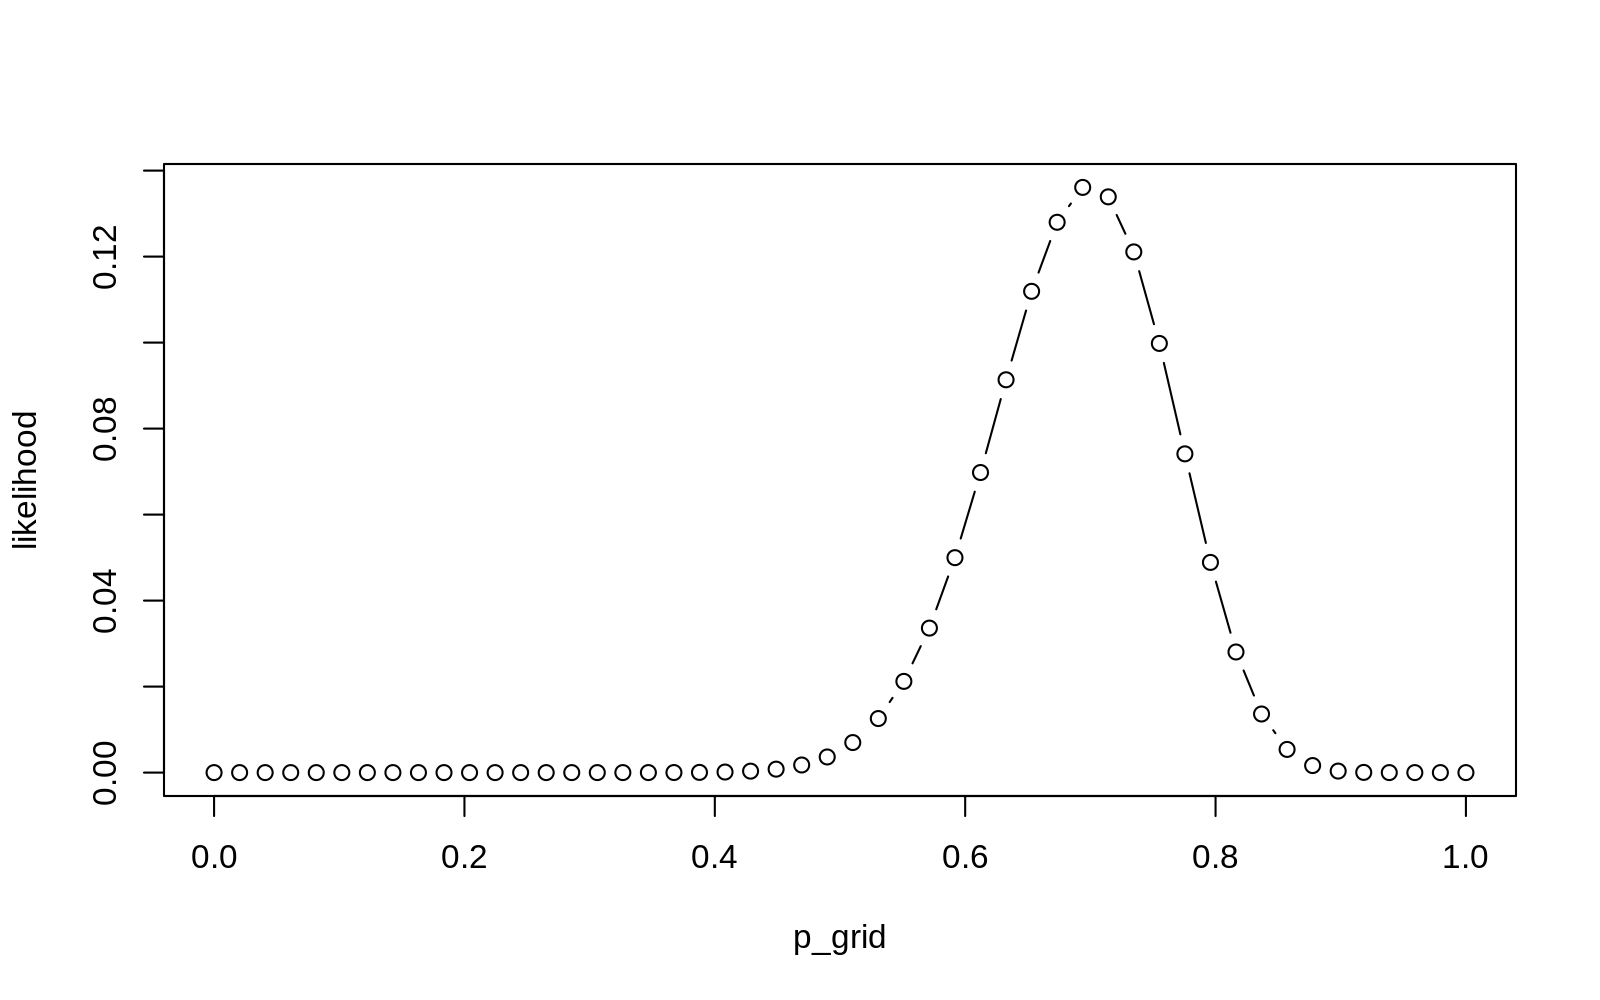

In [14]:
plot(p_grid, likelihood, type="b")

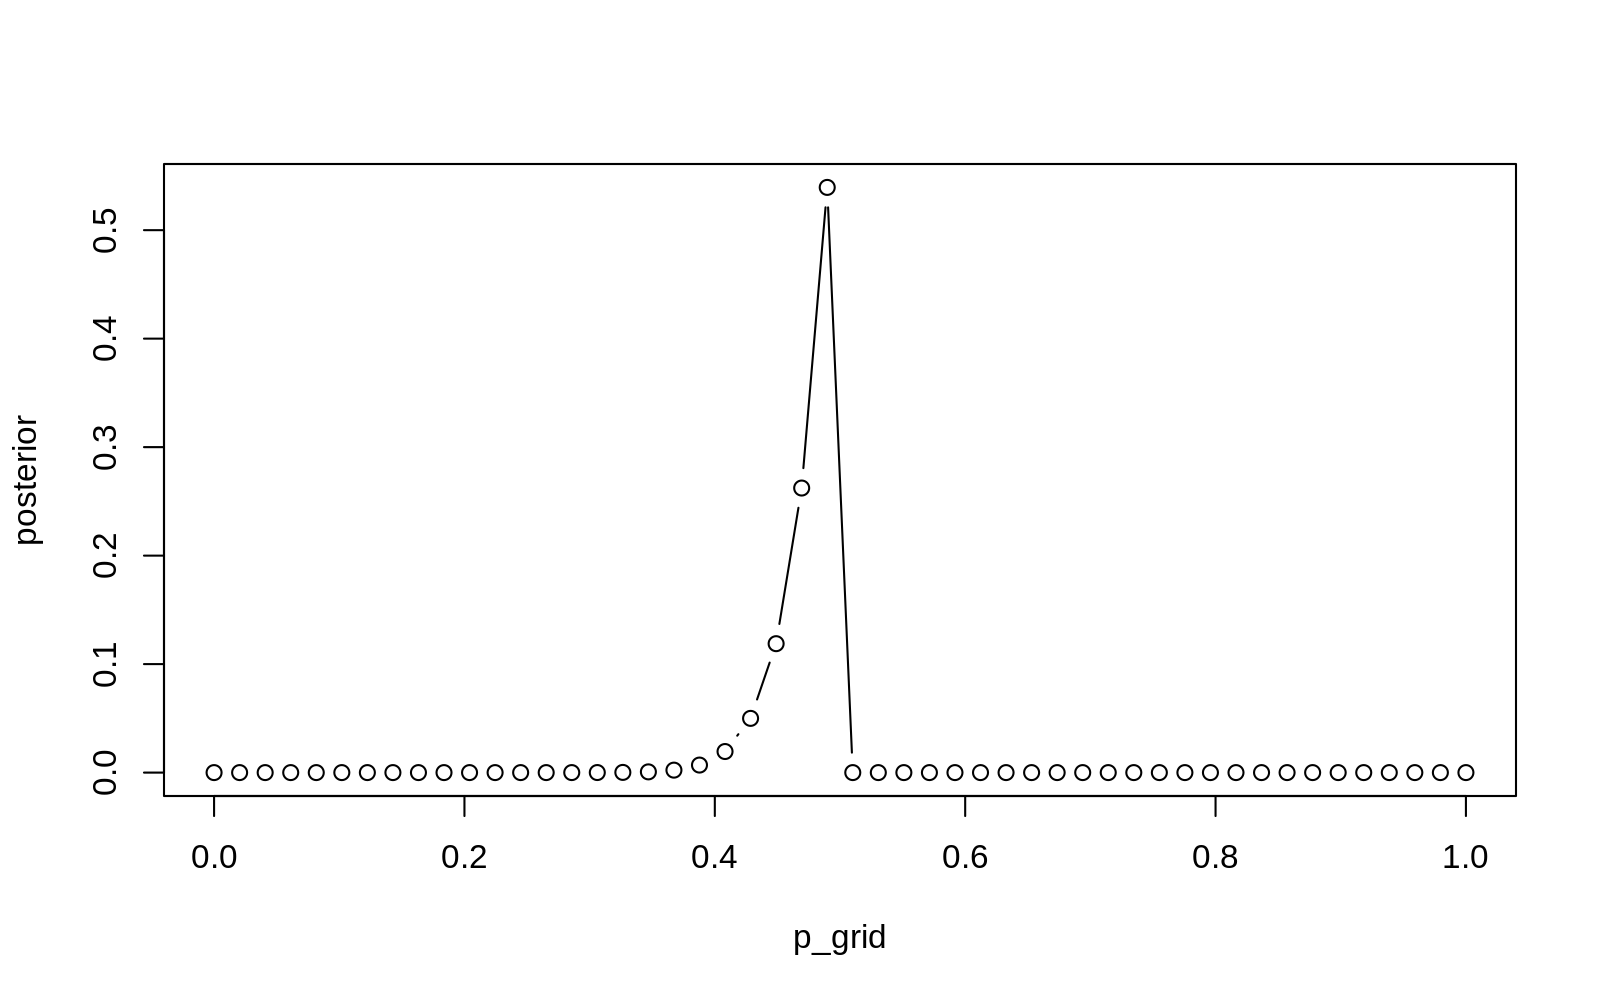

In [15]:
plot(p_grid, posterior, type="b")

But this grid approximation badly scales with the number of parameters + $p(Data)$ is hard to estimate when fitting LMM : __Markov Chain Monte Carlo__



MCMC boils down to generate new propositions of parameter values $\theta_{n+1}$ and compare to current proposal ($\theta_n$)

$current = \frac{p(\theta_n ) p(Data |\theta_n)}{p(Data)}$ 

$new = \frac{p(\theta_{n+1} ) p(Data |\theta_{n+1})}{p(Data)}$


Acceptance probability $p = \frac{p(\theta_{n+1} ) p(Data |\theta_{n+1})}{p(\theta_{n}) p(Data |\theta_{n})} $


Using these comparisons we explore the parameter space even though we do not compute $p(Data)$ (see blog post by [T. Wiecki](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) for an intuitive approach of the math behind MCMC sampling)

Let's illustrate MCMC and the different algorithm behind it : http://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=normal

To illustrate in the context of the R environment and to introduce the package  we are going to use  (_brms_) : we use an MCMC procedure to estimate the mean and sd of the known IQ distribution

In [16]:
set.seed(234)
options(mc.cores = parallel::detectCores())#Detects and stores the number of cores on your computer
library(brms)#Library for Bayesian estimation of LMMs (amongst other models)
library(shinystan)#Library we are going to use to inspect our MCMC procedures

Loading required package: Rcpp

Loading 'brms' package (version 2.14.4). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Loading required package: shiny


This is shinystan version 2.5.0




In [17]:
dummy_data = data.frame(y=rnorm(100, 100,15))#e.g. Normal with known mean of 100 and sd of 15

Setting large priors

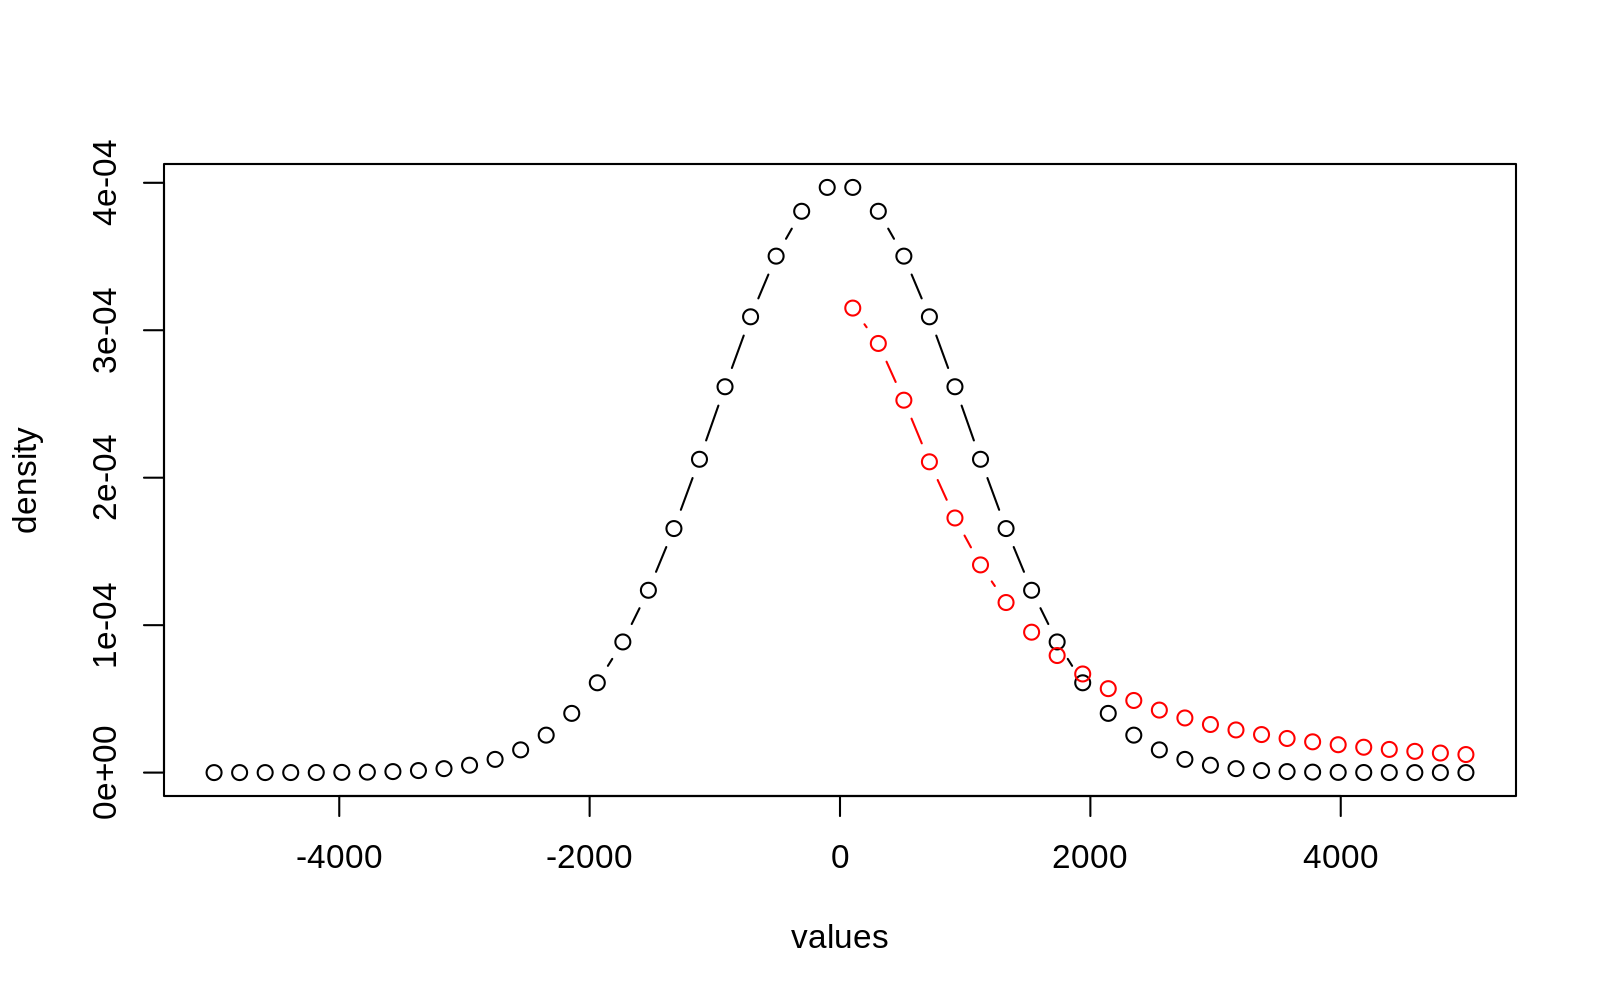

In [18]:
priors = c(prior(normal(0, 1000), class = Intercept),#The prior we have on the mean
    prior(cauchy(0, 1000), class = sigma))#The prior we have on the SD a fat-tailed truncated distribution
values = seq(from=-5000, to=5000, length.out = 50)
plot(values,dnorm(values,0,1000),type="b",ylab="density")
lines(values[26:50],dcauchy(values[26:50],0,1000),type="b",col="red")

Estimating the parameters

In [22]:
a_mean = brm(y ~ 1, data=dummy_data, 
             family="normal", prior = priors, chain = 2, warmup=10, iter=100)#A shotgun to a knife fight

Compiling Stan program...

recompiling to avoid crashing R session

Start sampling

Warning message:
“There were 2 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.93, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior 

In [23]:
print(stancode(a_mean))

// generated with brms 2.14.4
functions {
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // response variable
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
}
parameters {
  real Intercept;  // temporary intercept for centered predictors
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // likelihood including all constants
  if (!prior_only) {
    // initialize linear predictor term
    vector[N] mu = Intercept + rep_vector(0.0, N);
    target += normal_lpdf(Y | mu, sigma);
  }
  // priors including all constants
  target += normal_lpdf(Intercept | 0, 1000);
  target += cauchy_lpdf(sigma | 0, 1000)
    - 1 * cauchy_lccdf(0 | 0, 1000);
}
generated quantities {
  // actual population-level intercept
  real b_Intercept = Intercept;
}


Let's inspect the MCMC algorithm

No divergences to plot.



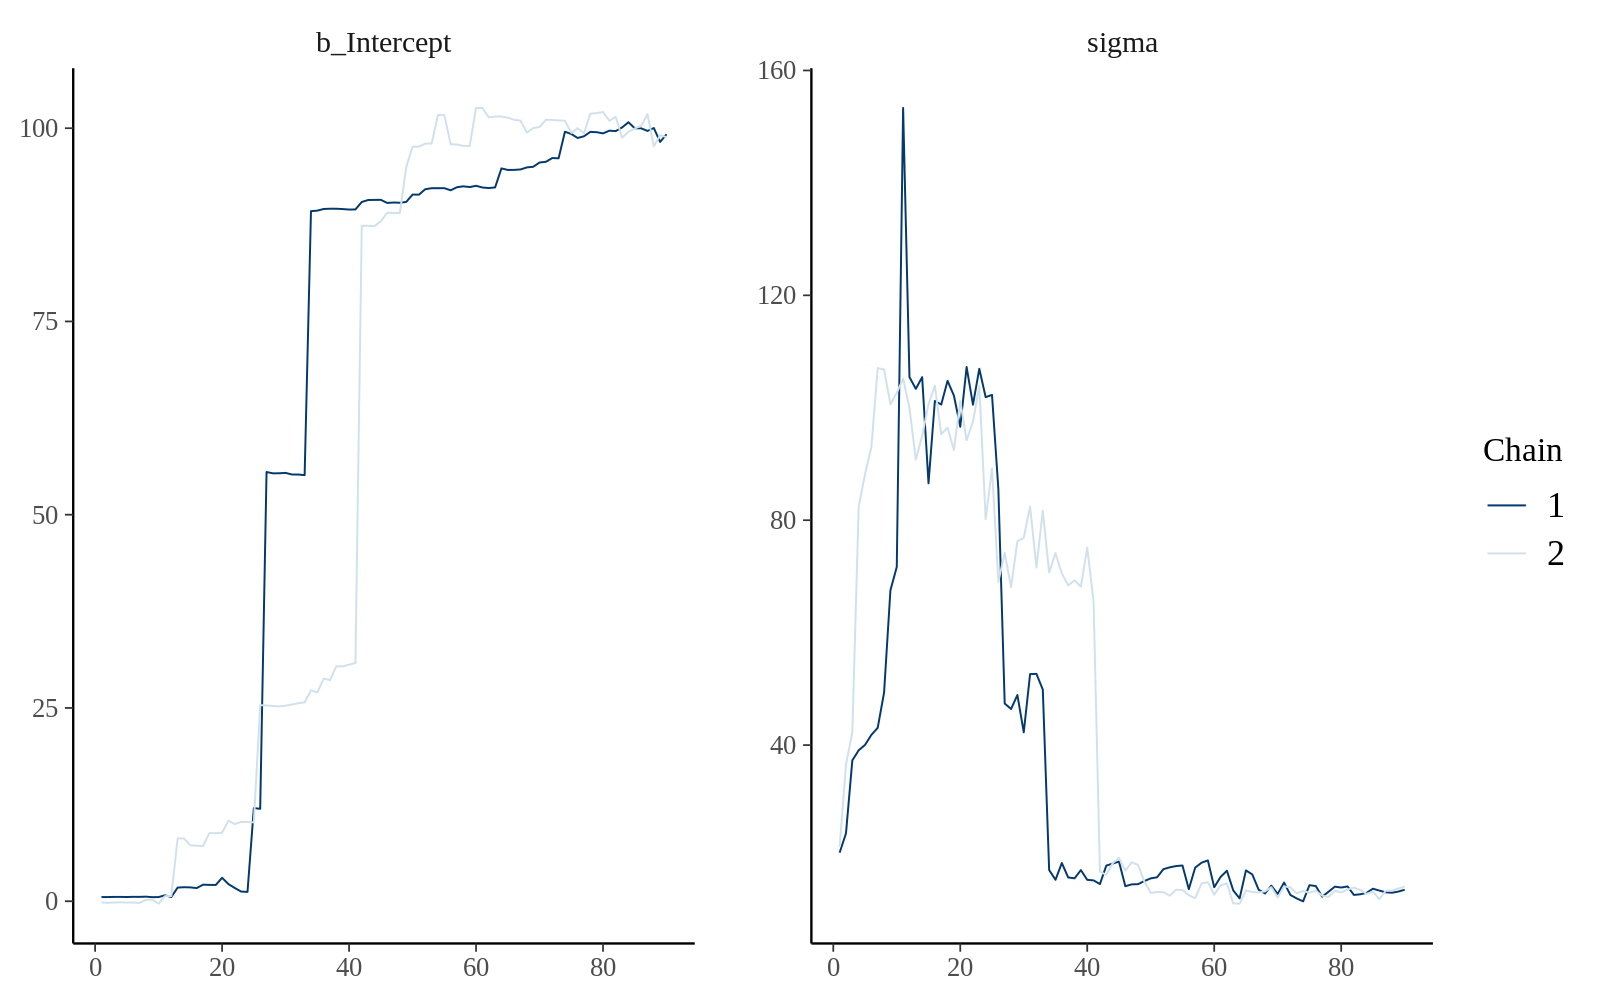

In [24]:
mcmc_plot(a_mean, type="trace")

In [25]:
summary(a_mean)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ 1 
   Data: dummy_data (Number of observations: 100) 
Samples: 2 chains, each with iter = 100; warmup = 10; thin = 1;
         total post-warmup samples = 180

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    62.14     42.41    -0.17   101.85 1.93        3       12

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    41.31     35.60    12.72   106.16 1.75        3       49

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

Note that there are numerous ways to check convergence and model adequacy, _e.g._ shinystan

In [24]:
options(browser = "firefox")
launch_shinystan(a_mean)


Launching ShinyStan interface... for large models this  may take some time.


Listening on http://127.0.0.1:3383



> How can you improve the estimation ? Try it yourself

- Increasing n of warm-ups ensures that your MCMC have the same stationnary distribution (R-hat)
- Increasing the n of recorded iterations increases the precision of the posterior distributions
- Increasing chains increases the available number of samples and ensure to diagnose single chain mis-behaviour (e.g. stucked chain, local minima departure,...)

Prior predictive checks : 
- draw $\theta$ (e.g. $\mu$ and $\sigma$) from defined priors
- generate samples from a distribution with that $\theta$

Compiling Stan program...

Start sampling



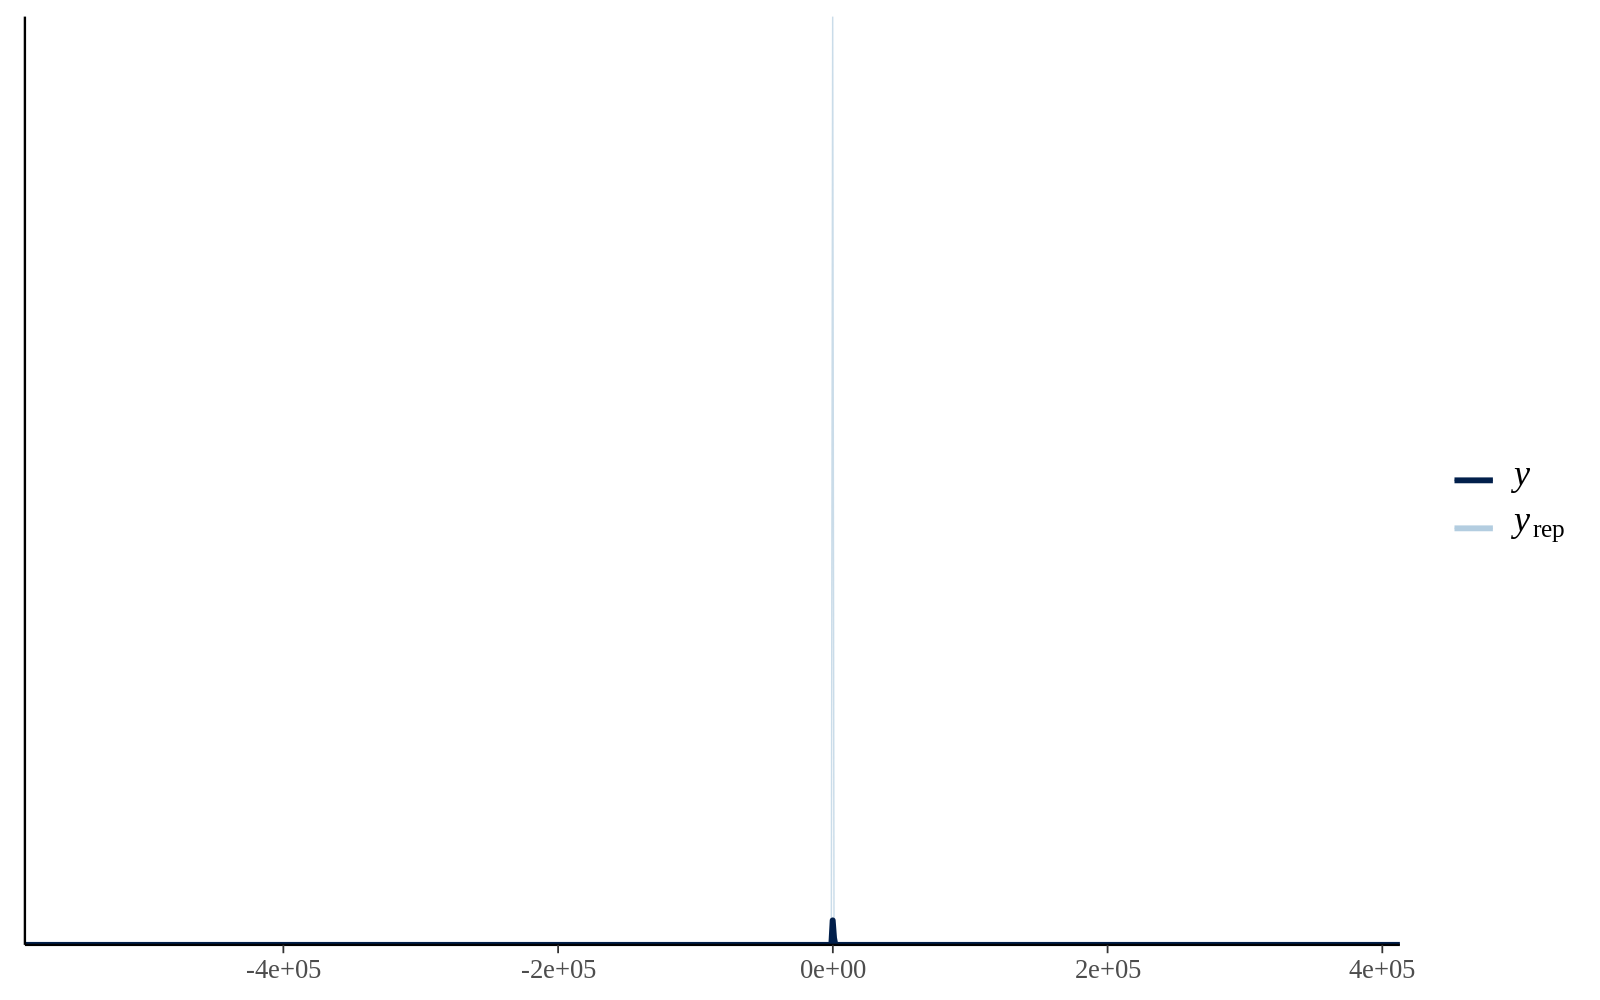

In [25]:
a_mean_prior_only = brm(y ~ 1, data=dummy_data, sample_prior = "only",
             family="normal", prior = priors, chain = 4, cores=5, warmup=500, iter=1000)
pp_check(nsamples = 100, a_mean_prior_only)

Priors are inconsistent with domain knowledge about IQ. Let's induce some more informative priors

Compiling Stan program...

Start sampling

Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


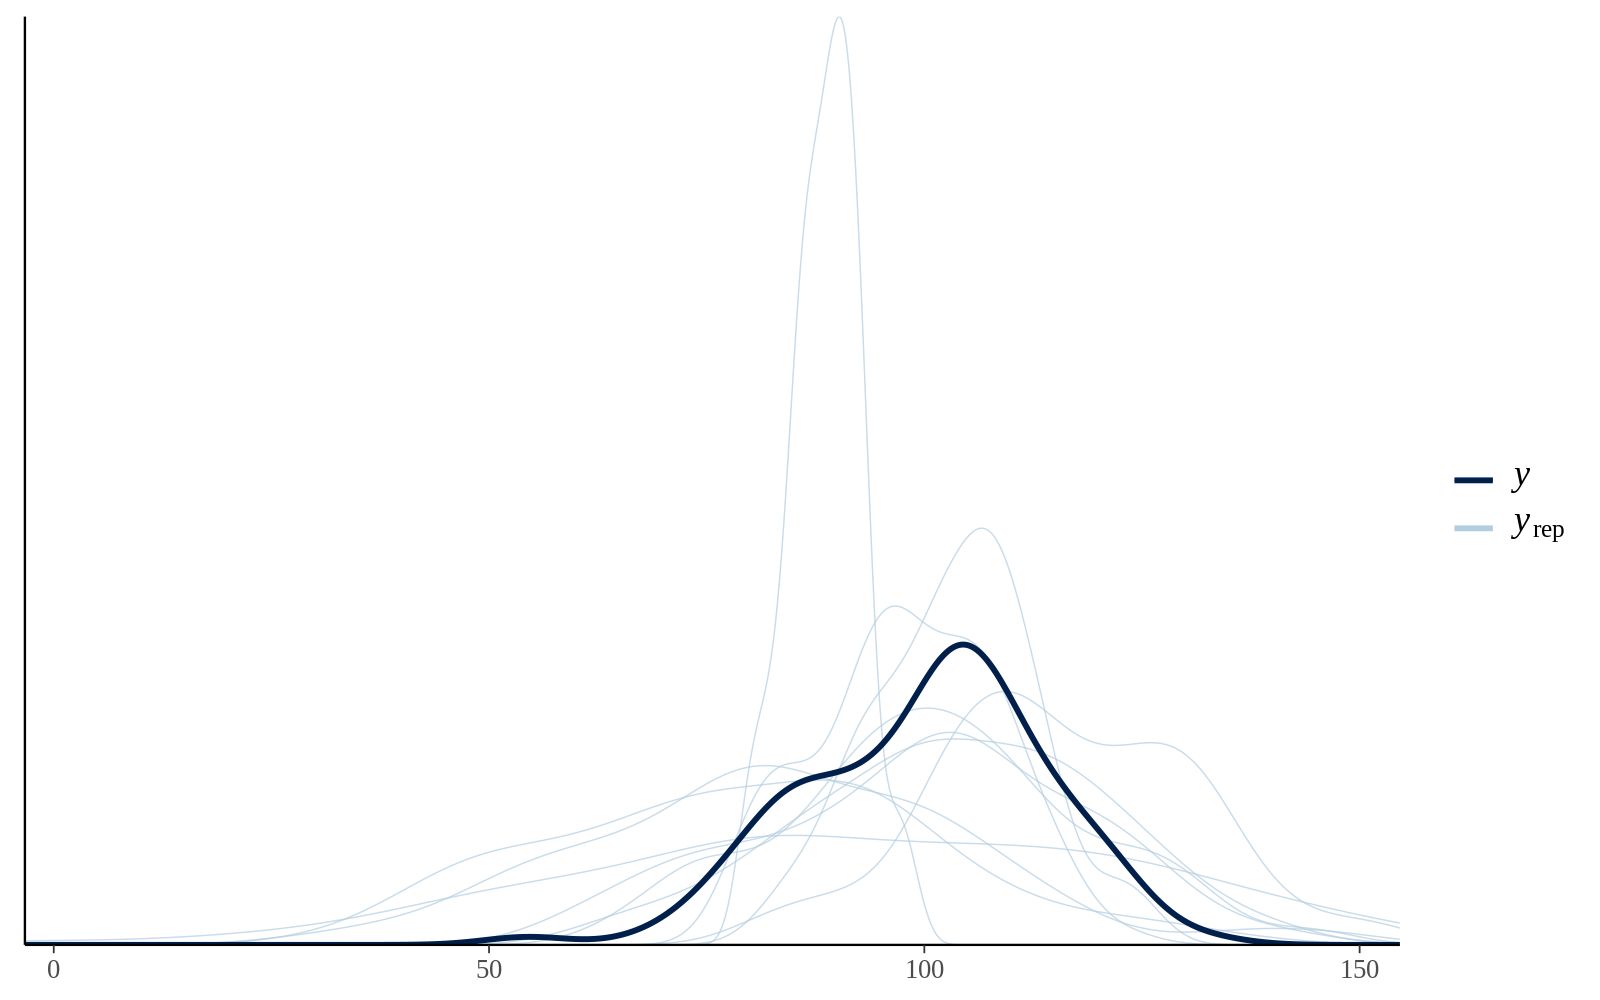

In [26]:
priors = c(prior(normal(100, 10), class = Intercept),#The prior we have on the mean
    prior(cauchy(15, 5), class = sigma))#The prior we have on the SD a fat-tailed truncated distribution
a_mean_prior_only = brm(y ~ 1, data=dummy_data, sample_prior = "only",
             family="normal", prior = priors, chain = 4, cores=5, warmup=500, iter=1000)
pp_check(nsamples = 10, a_mean_prior_only)

Posterior predictive checks : 
- draw $\theta$ (e.g. $\mu$ and $\sigma$) from estimated posterior
- generate samples from a distribution with that $\theta$

Compiling Stan program...

Start sampling



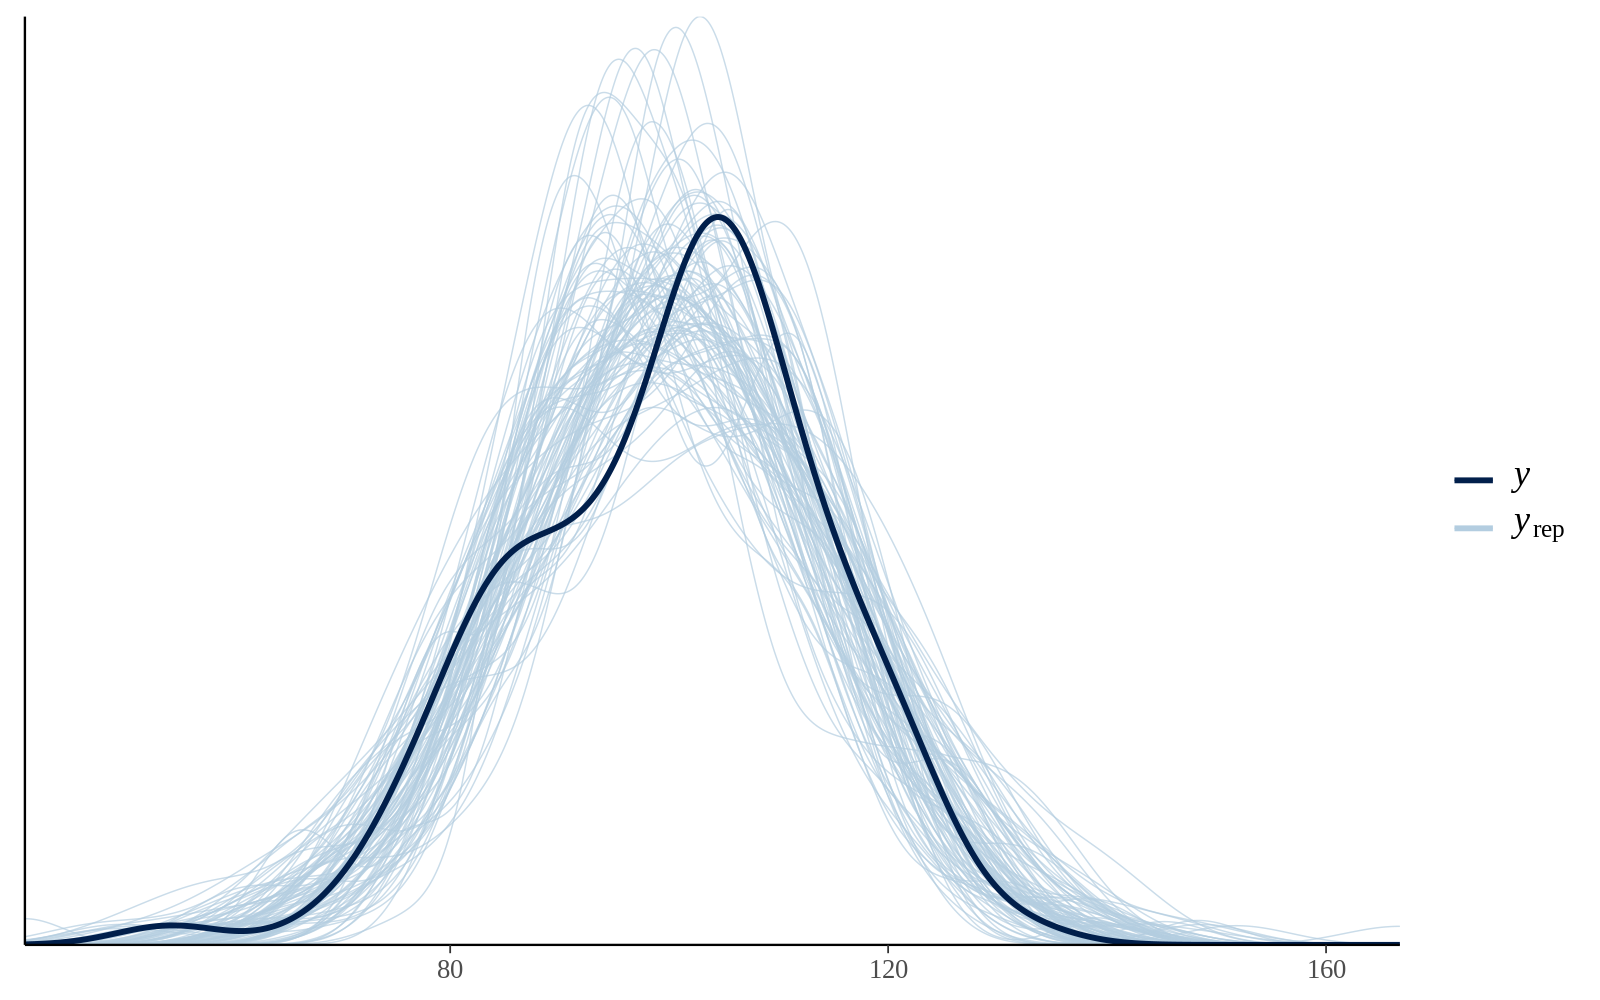

In [27]:
a_mean = brm(y ~ 1, data=dummy_data, 
             family="normal", prior = priors, chain = 4, cores=5, warmup=500, iter=1000)
pp_check(nsamples = 100, a_mean)

If we induced improper priors : 

Compiling Stan program...

Start sampling



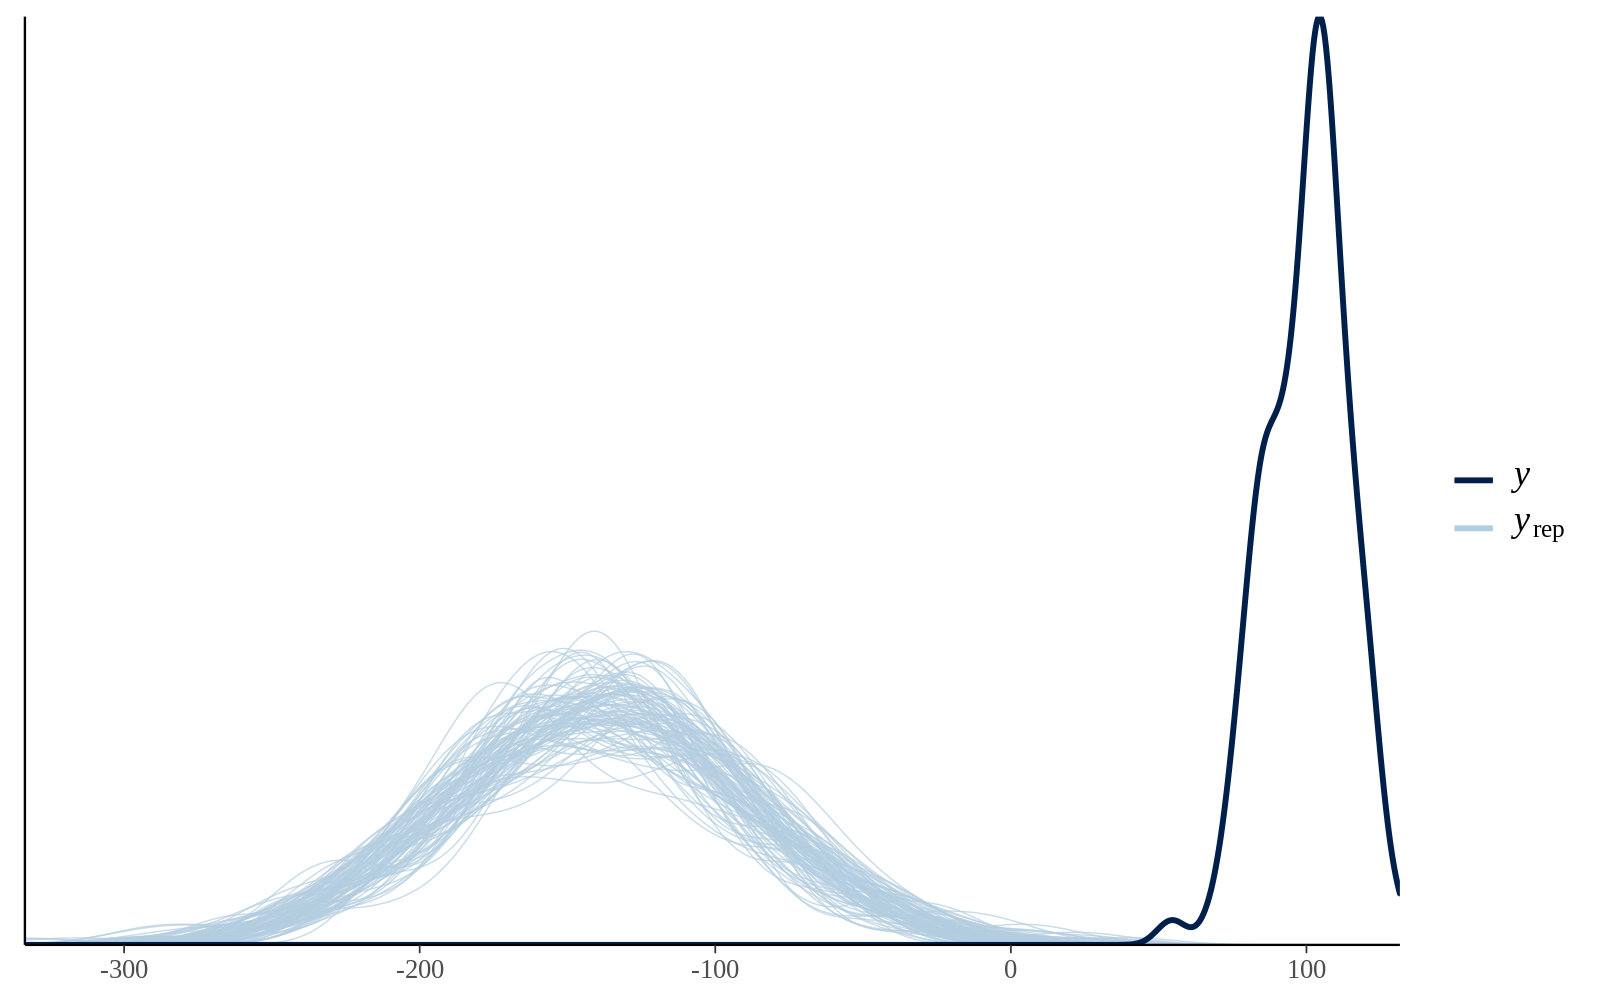

In [28]:
improper_priors = c(prior(normal(-150, 1), class = Intercept),#The (wrong) prior we have on the mean
    prior(normal(1, 1), class = sigma))#Bad prior on variance
a_mean_improper = brm(y ~ 1, data=dummy_data, #Note that the model is slower to fit
             family="normal", prior = improper_priors, chain = 4, cores=5, warmup=500, iter=1000)
pp_check(nsamples = 100, a_mean_improper)

But summaries (e.g. Rhat) do not explicitely show the problem

In [29]:
summary(a_mean_improper)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: y ~ 1 
   Data: dummy_data (Number of observations: 100) 
Samples: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup samples = 2000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept  -139.93      0.97  -141.81  -138.07 1.00     1390     1226

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    48.77      0.51    47.78    49.75 1.00     1894     1495

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

However if the prior do not exclude the real values, even improper priors will be overruled by the likelihood of the data (given a reasonable amount of it) :

Compiling Stan program...

Start sampling



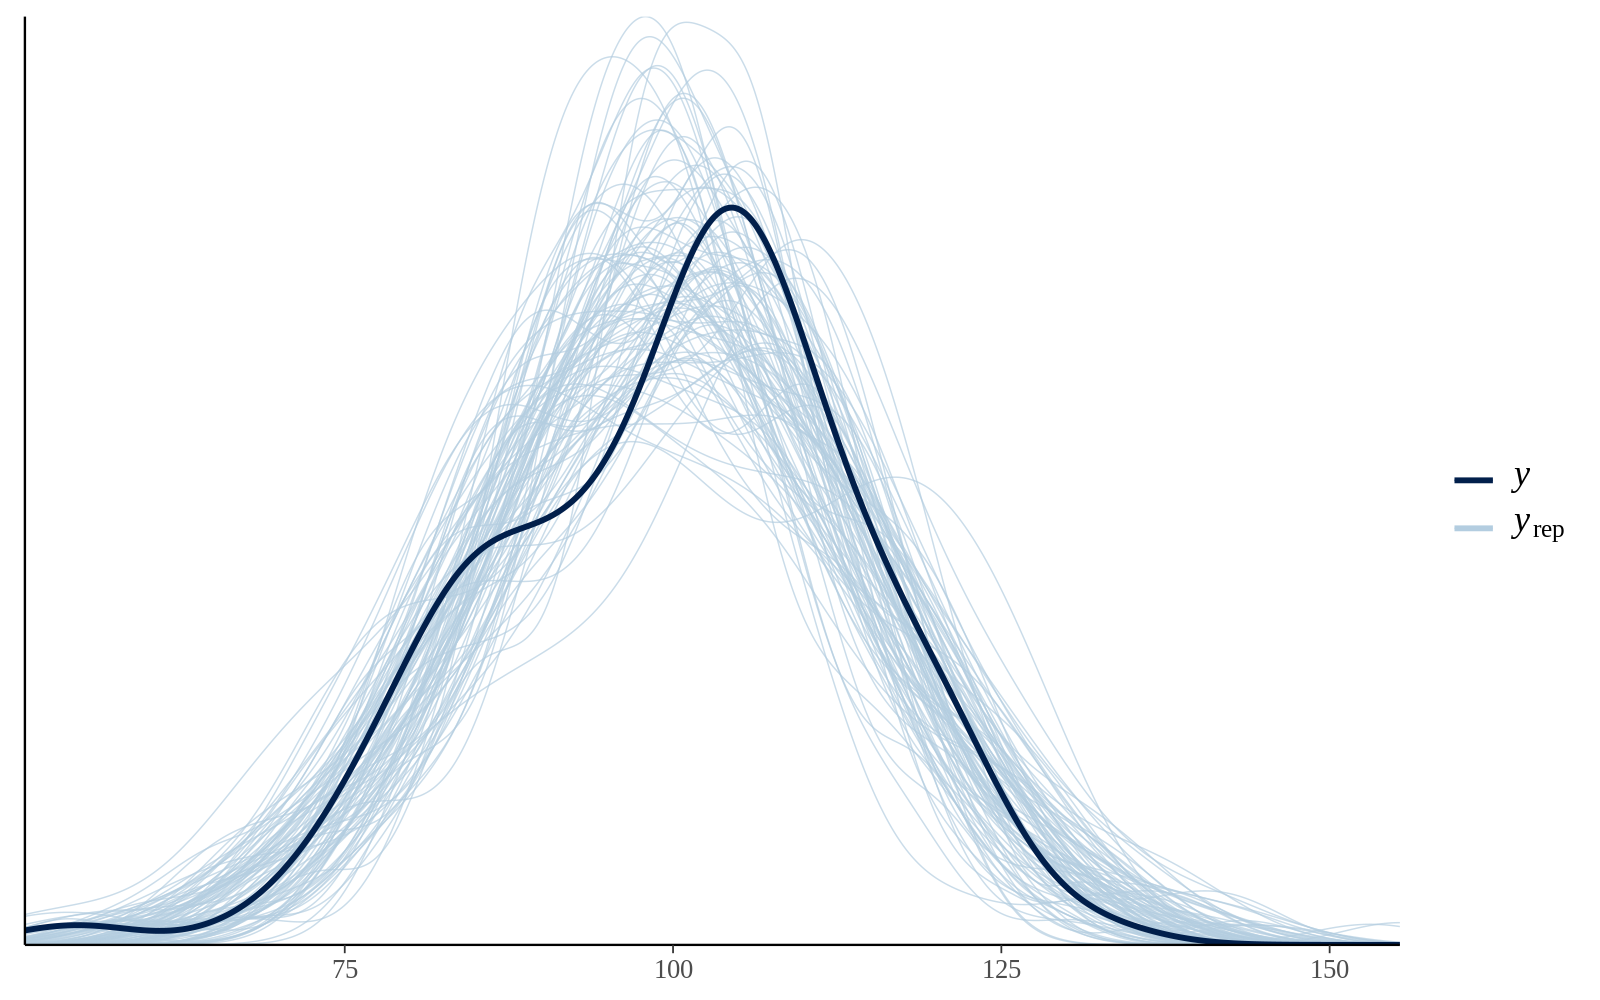

In [30]:
slightly_improper_priors = c(prior(normal(-150, 100), class = Intercept),#We increased the variance around our prior
    prior(cauchy(1, 1), class = sigma))#From normal to Cauchy
a_mean_slightly_improper = brm(y ~ 1, data=dummy_data, #Note that the model is slower to fit
             family="normal", prior = slightly_improper_priors, chain = 4, cores=5, warmup=500, iter=1000)
pp_check(nsamples = 100, a_mean_slightly_improper)

We move to linear models using the dataset we generated in module 2 : 

In [31]:
library(MASS)
mean_wm = 6
sd_wm = 1
n_participants = 15

varcovmat = matrix(c(1, .33, .33, .33, .33, 1, .33, .33, .33, .33,1,.33, .33, .33, .33,1), nrow=4)
data = data.frame()
for(i in 1:n_participants){
    re = mvrnorm(n=1, mu=c(0, 0, 0, 0), Sigma=varcovmat)
    mu_i = re[1] * sd_wm + mean_wm
    b_age = re[2] *(sd_wm*2) - (sd_wm*4) #b_age_j
    b_task = re[3] * sd_wm + -(sd_wm*2)#b_task_j
    b_age_task = re[4] * (sd_wm/2) - (sd_wm*2)#b_agetask_j
    age_tested = runif(runif(1, 5,15), 1, 99)
    for (age in age_tested){# for loop in for loops is especially dirty but more transparent
        age = age/100#We recode age for scale purpose
        for (task in c(0,1)){
            ntrials = runif(1, 50, 150)
            subdata = data.frame(trial=1:ntrials)
            mu = mu_i+b_age*age+b_task*task+b_age_task*age*task
            subdata$wm = rnorm(ntrials, mu, sd=sd_wm)
            subdata$participant = as.character(i)
            subdata$age = age 
            subdata$task = task
            data = rbind(data, subdata)
        }
    }
}
means_ = aggregate(data$wm, FUN=mean, 
          by=list(age=data$age, task=data$task, participant = data$participant))#pre-averaging at first

In [32]:
#We let brms use the default priors out of commodity
blm0 = brm(x ~ age * task, data=means_, 
             family="normal", chain = 4, cores=4, warmup=500, iter=1000)

Compiling Stan program...

Start sampling



In [33]:
print(stancode(blm0))

// generated with brms 2.14.4
functions {
}
data {
  int<lower=1> N;  // total number of observations
  vector[N] Y;  // response variable
  int<lower=1> K;  // number of population-level effects
  matrix[N, K] X;  // population-level design matrix
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc = K - 1;
  matrix[N, Kc] Xc;  // centered version of X without an intercept
  vector[Kc] means_X;  // column means of X before centering
  for (i in 2:K) {
    means_X[i - 1] = mean(X[, i]);
    Xc[, i - 1] = X[, i] - means_X[i - 1];
  }
}
parameters {
  vector[Kc] b;  // population-level effects
  real Intercept;  // temporary intercept for centered predictors
  real<lower=0> sigma;  // residual SD
}
transformed parameters {
}
model {
  // likelihood including all constants
  if (!prior_only) {
    target += normal_id_glm_lpdf(Y | Xc, Intercept, b, sigma);
  }
  // priors including all constants
  target += student_t_lpdf(Intercept | 3, 2.5, 3.2);
  target

In [34]:
blm0

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: x ~ age * task 
   Data: means_ (Number of observations: 272) 
Samples: 4 chains, each with iter = 1000; warmup = 500; thin = 1;
         total post-warmup samples = 2000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     5.59      0.42     4.74     6.37 1.00      897     1163
age          -3.56      0.71    -4.85    -2.12 1.00      951     1124
task         -1.84      0.57    -2.97    -0.70 1.00      845      979
age:task     -2.23      0.98    -4.11    -0.33 1.00      839     1015

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     2.34      0.10     2.14     2.56 1.00     1569     1223

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

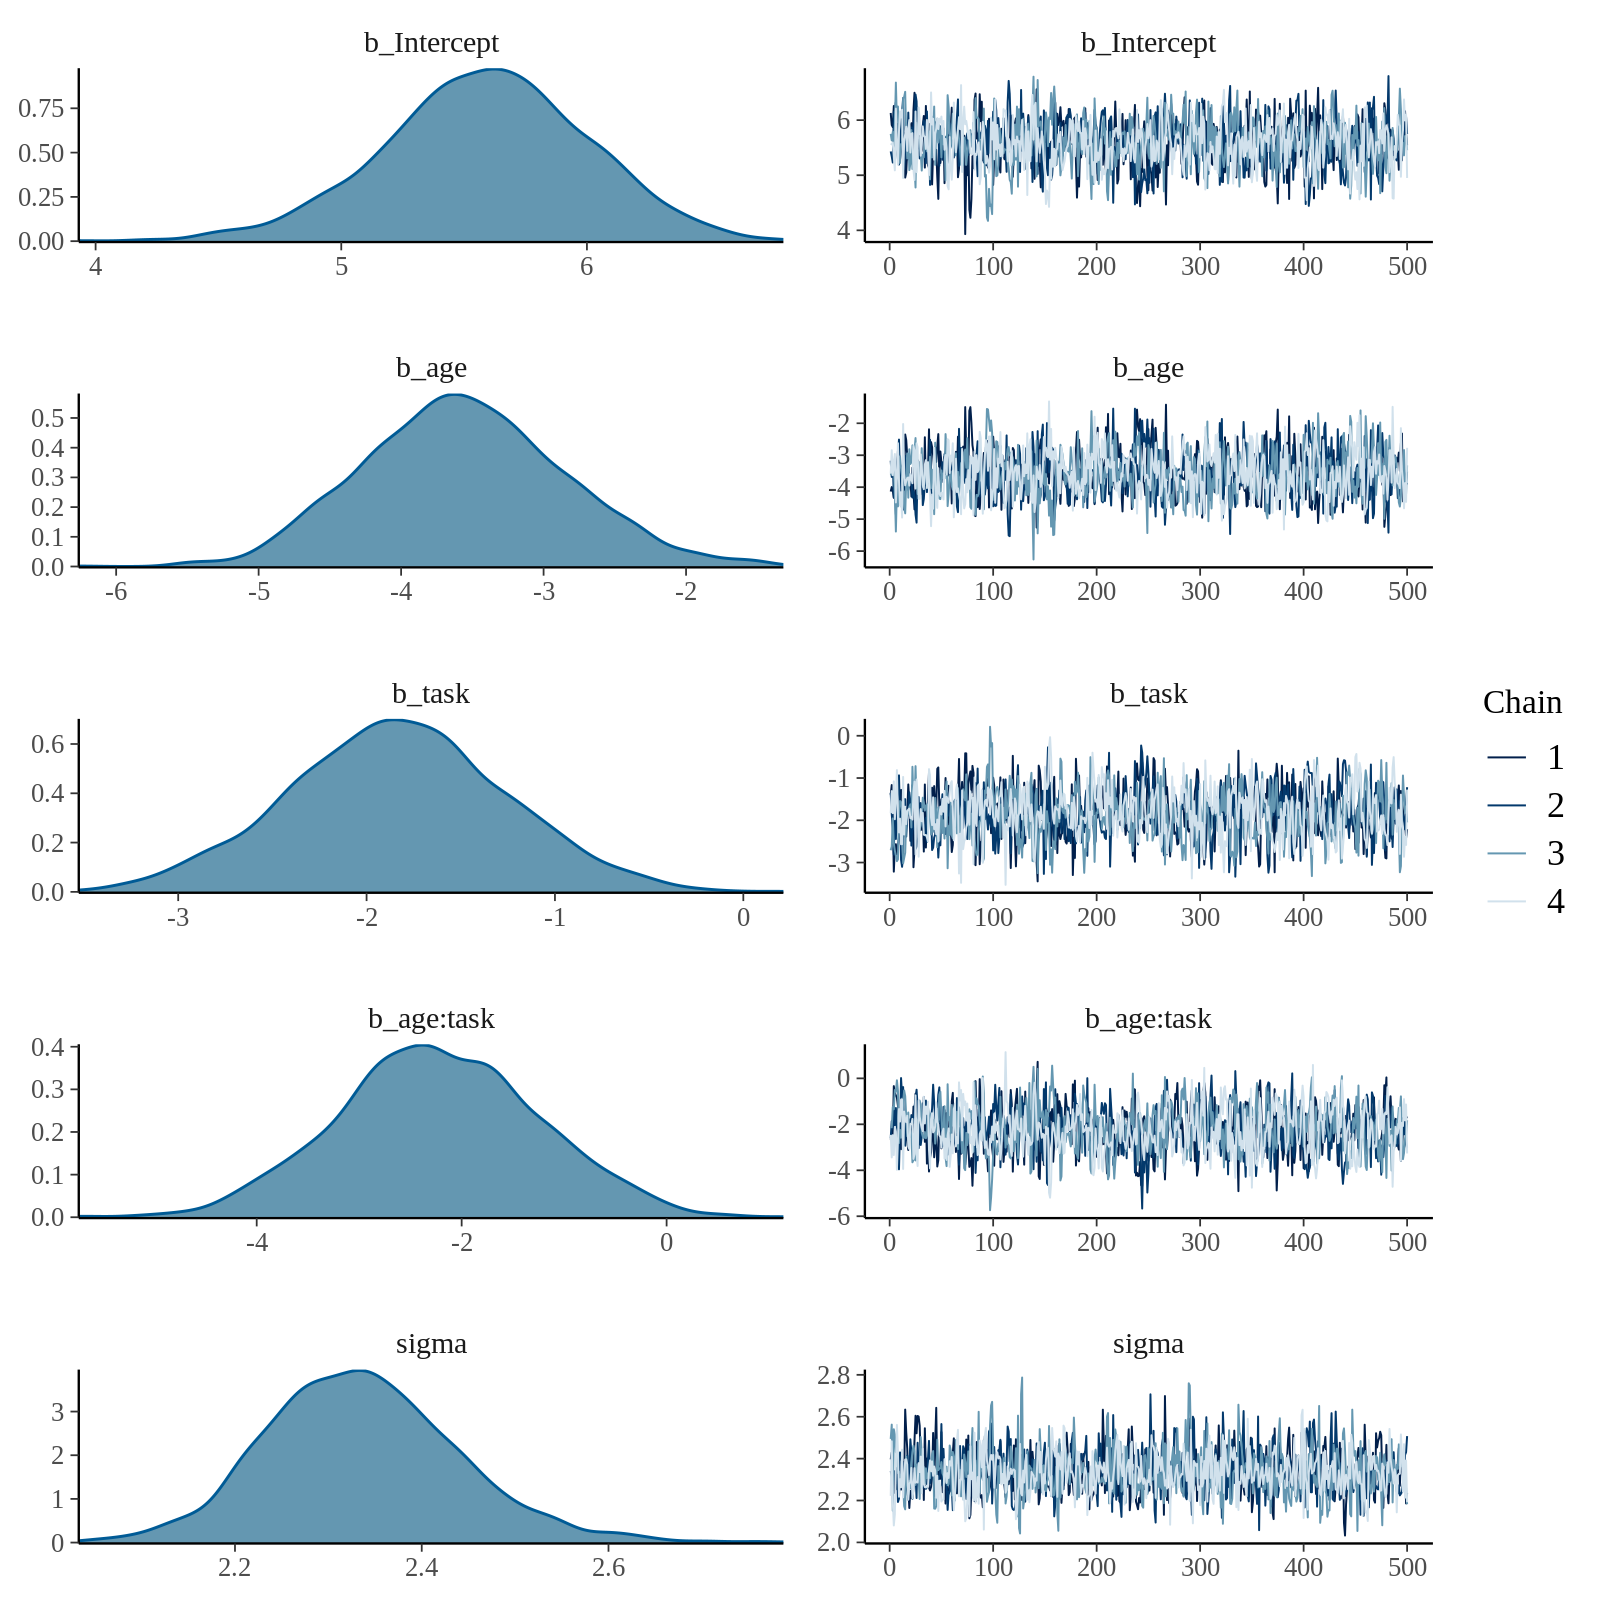

In [35]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res = 200)#hidden code for display size
plot(blm0)
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size

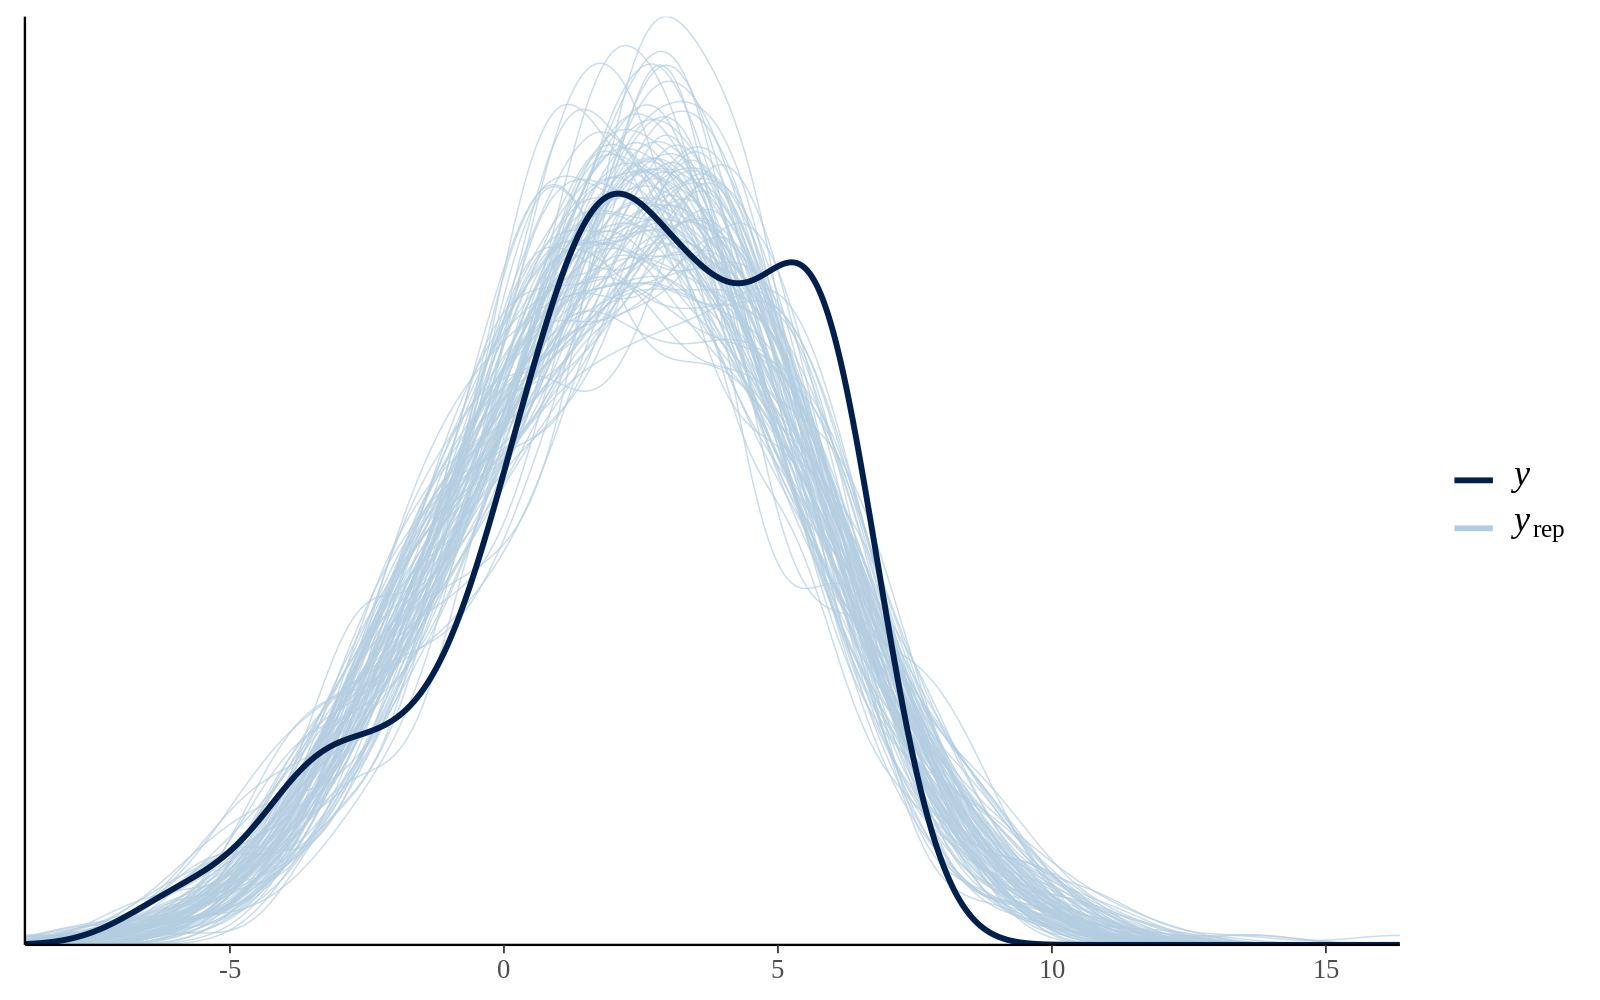

In [36]:
pp_check(nsamples = 100, blm0)

Every point raised until now in the course apply, e.g. we can check for normality and homeoscedasticity of the residuals

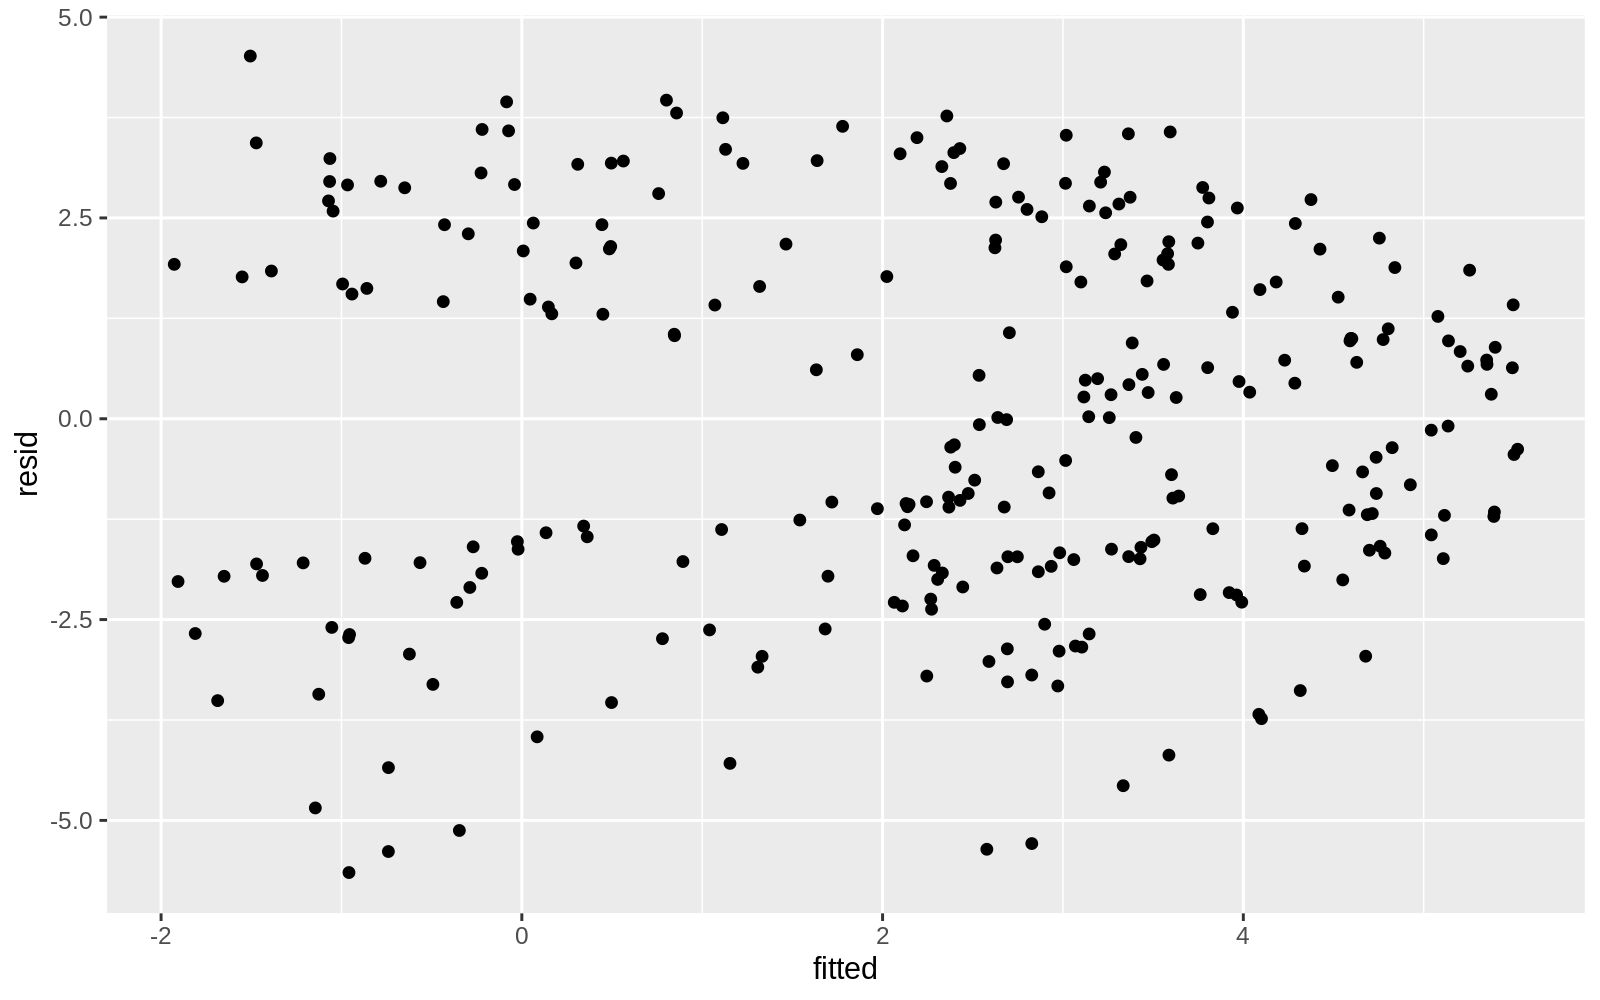

In [37]:
library(ggplot2)
fitted <- fitted(blm0)[, 1]
resid <- residuals(blm0)[, 1]

qplot(fitted, resid)

We see that there is some heteroscedasticity, we applied the wrong model as also seen in the estimation of the residual SD (but see full LMM)

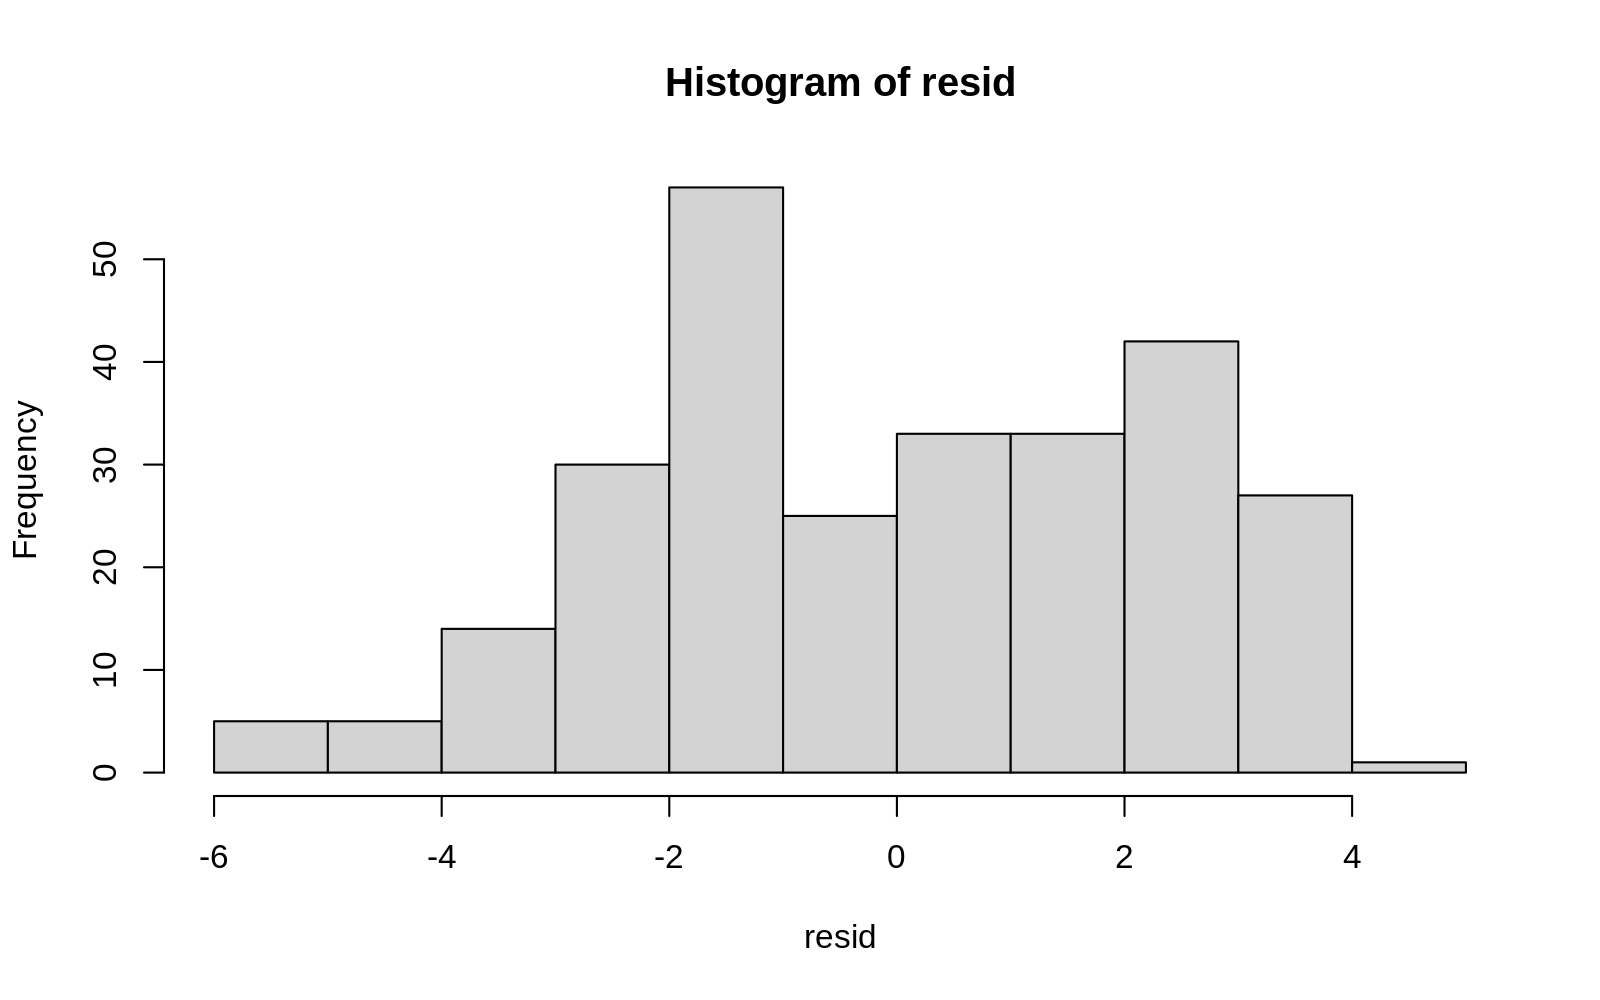

In [38]:
hist(resid)

We can also look at the correlation between parameter estimation

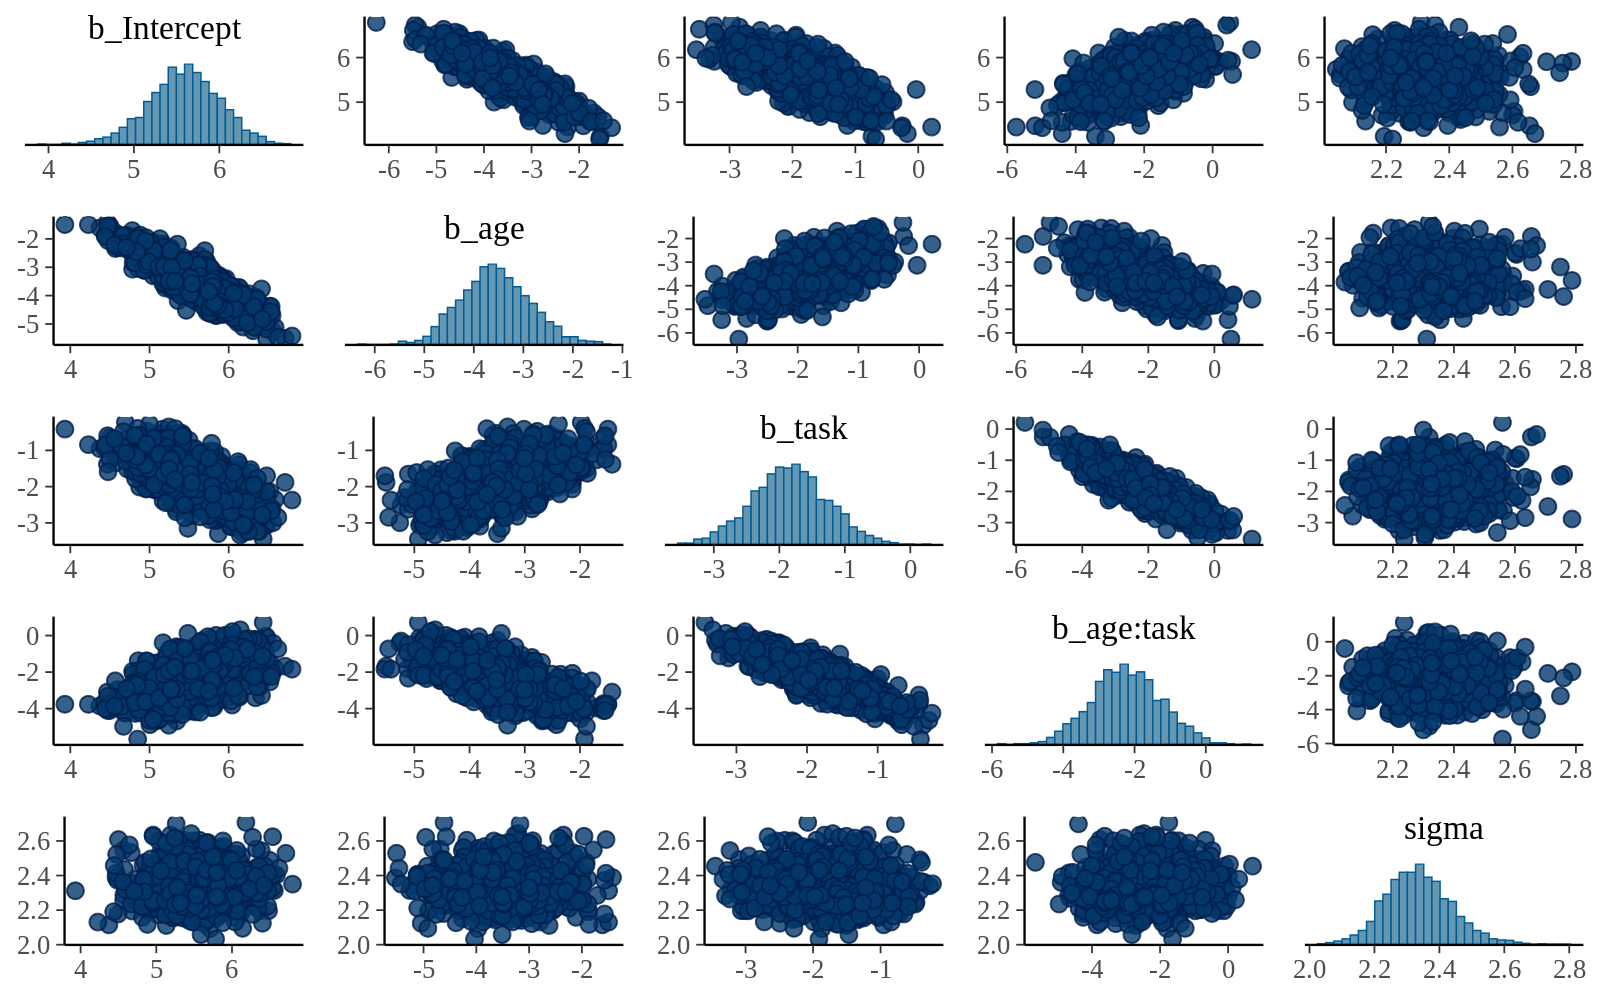

In [39]:
pairs(blm0)

Bayesian estimation allows you to easily use the uncertainty associated with the estimation of parameters. _E.g._ we can draw 500 regression lines from the posterior distribution


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidybayes’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t




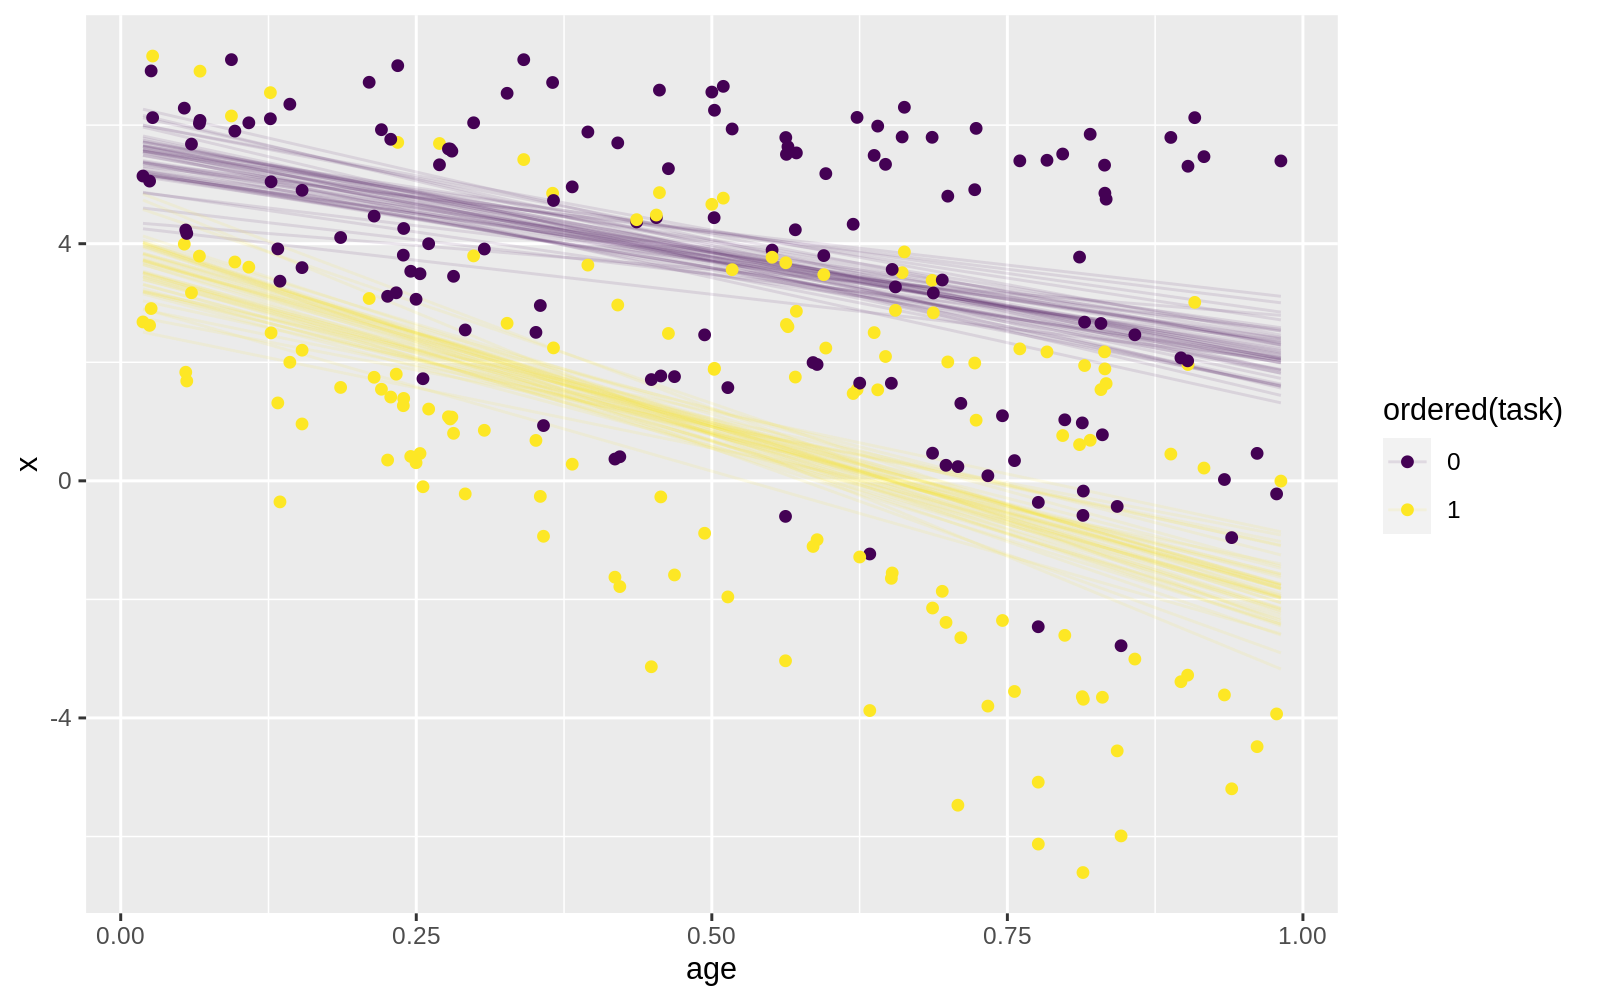

In [40]:
#install.packages('tidybayes') see http://mjskay.github.io/tidybayes/articles/tidy-brms.html
library(dplyr)
library(ggplot2)
library(tidybayes)
library(modelr)
means_ %>%
  group_by(task) %>%
  data_grid(age = seq_range(age, n = 100)) %>%
  add_fitted_draws(blm0, n = 50) %>%
  ggplot(aes(x = age, y = x, color = ordered(task))) +
  geom_line(aes(y = .value, group = paste(task, .draw)), alpha = .1) +
  geom_point(data = means_) 

Additionally MCMC process allows you to access the estimates of each iteration 

In [41]:
get_variables(blm0)

[1] "b_Intercept"   "b_age"         "b_task"        "b_age:task"   
 [5] "sigma"         "lp__"          "accept_stat__" "stepsize__"   
 [9] "treedepth__"   "n_leapfrog__"  "divergent__"   "energy__"

Imagine you want to compute the predicted wm at age 70 but keeping the uncertainty associated with the parameters

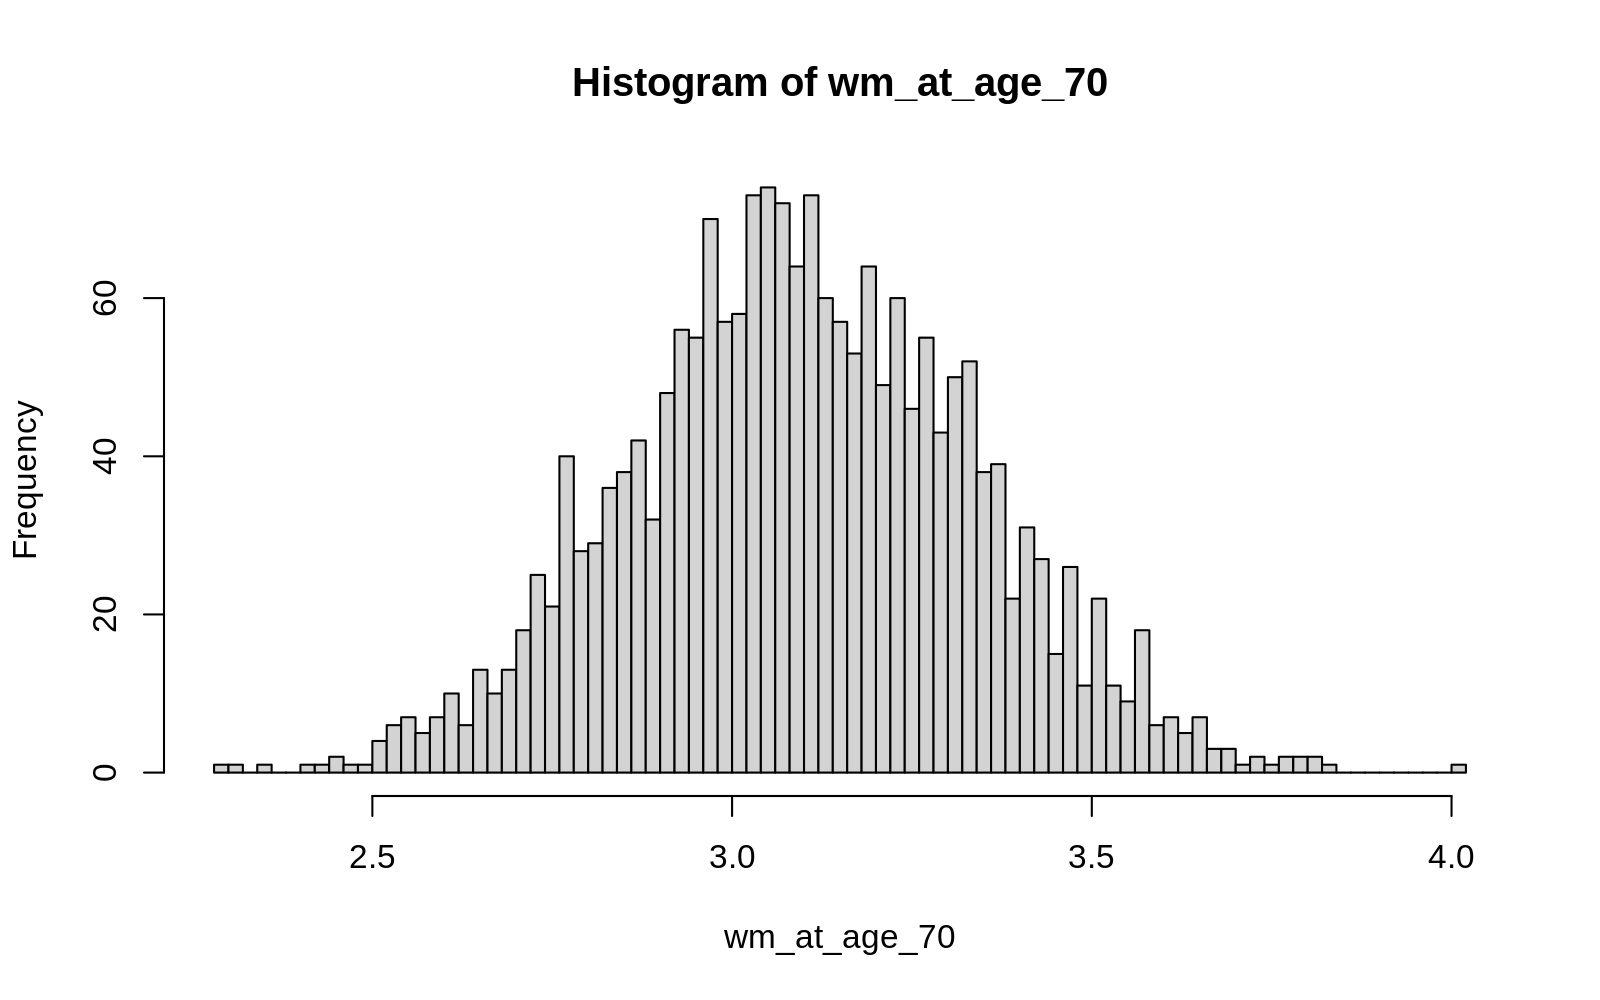

In [42]:
intercept = blm0 %>% spread_draws(b_Intercept)
slope_age = blm0 %>% spread_draws(b_age)
wm_at_age_70 = intercept$b_Intercept + slope_age$b_age*.70
hist(wm_at_age_70,breaks=100)

Now directly to full linear mixed models

In [43]:
priors = c(prior(normal(6, 2), class = Intercept),#The prior we have on the intercept
    prior(cauchy(1, 5), class = sigma),#The prior we have on the SD a fat-tailed truncated distribution
    prior(normal(0,10), class = b, coef=age),#prior on the age effect
    prior(normal(0,10), class = b, coef=task),#prior on the task effect
    prior(normal(0,10), class = b, coef=age:task),#prior on the interaction between age and task
    prior(lkj(2), class = cor))#prior on the correlation between RE

#The following is too slow to be run in class so I just recover it from a previous fit
blm1 = brm(wm ~ age * task + (age * task | participant), data=data, prior = priors,
             family="normal", chain = 8, cores=8, warmup=1000, iter=1200, file="blm1")

Plotting the __population parameters__

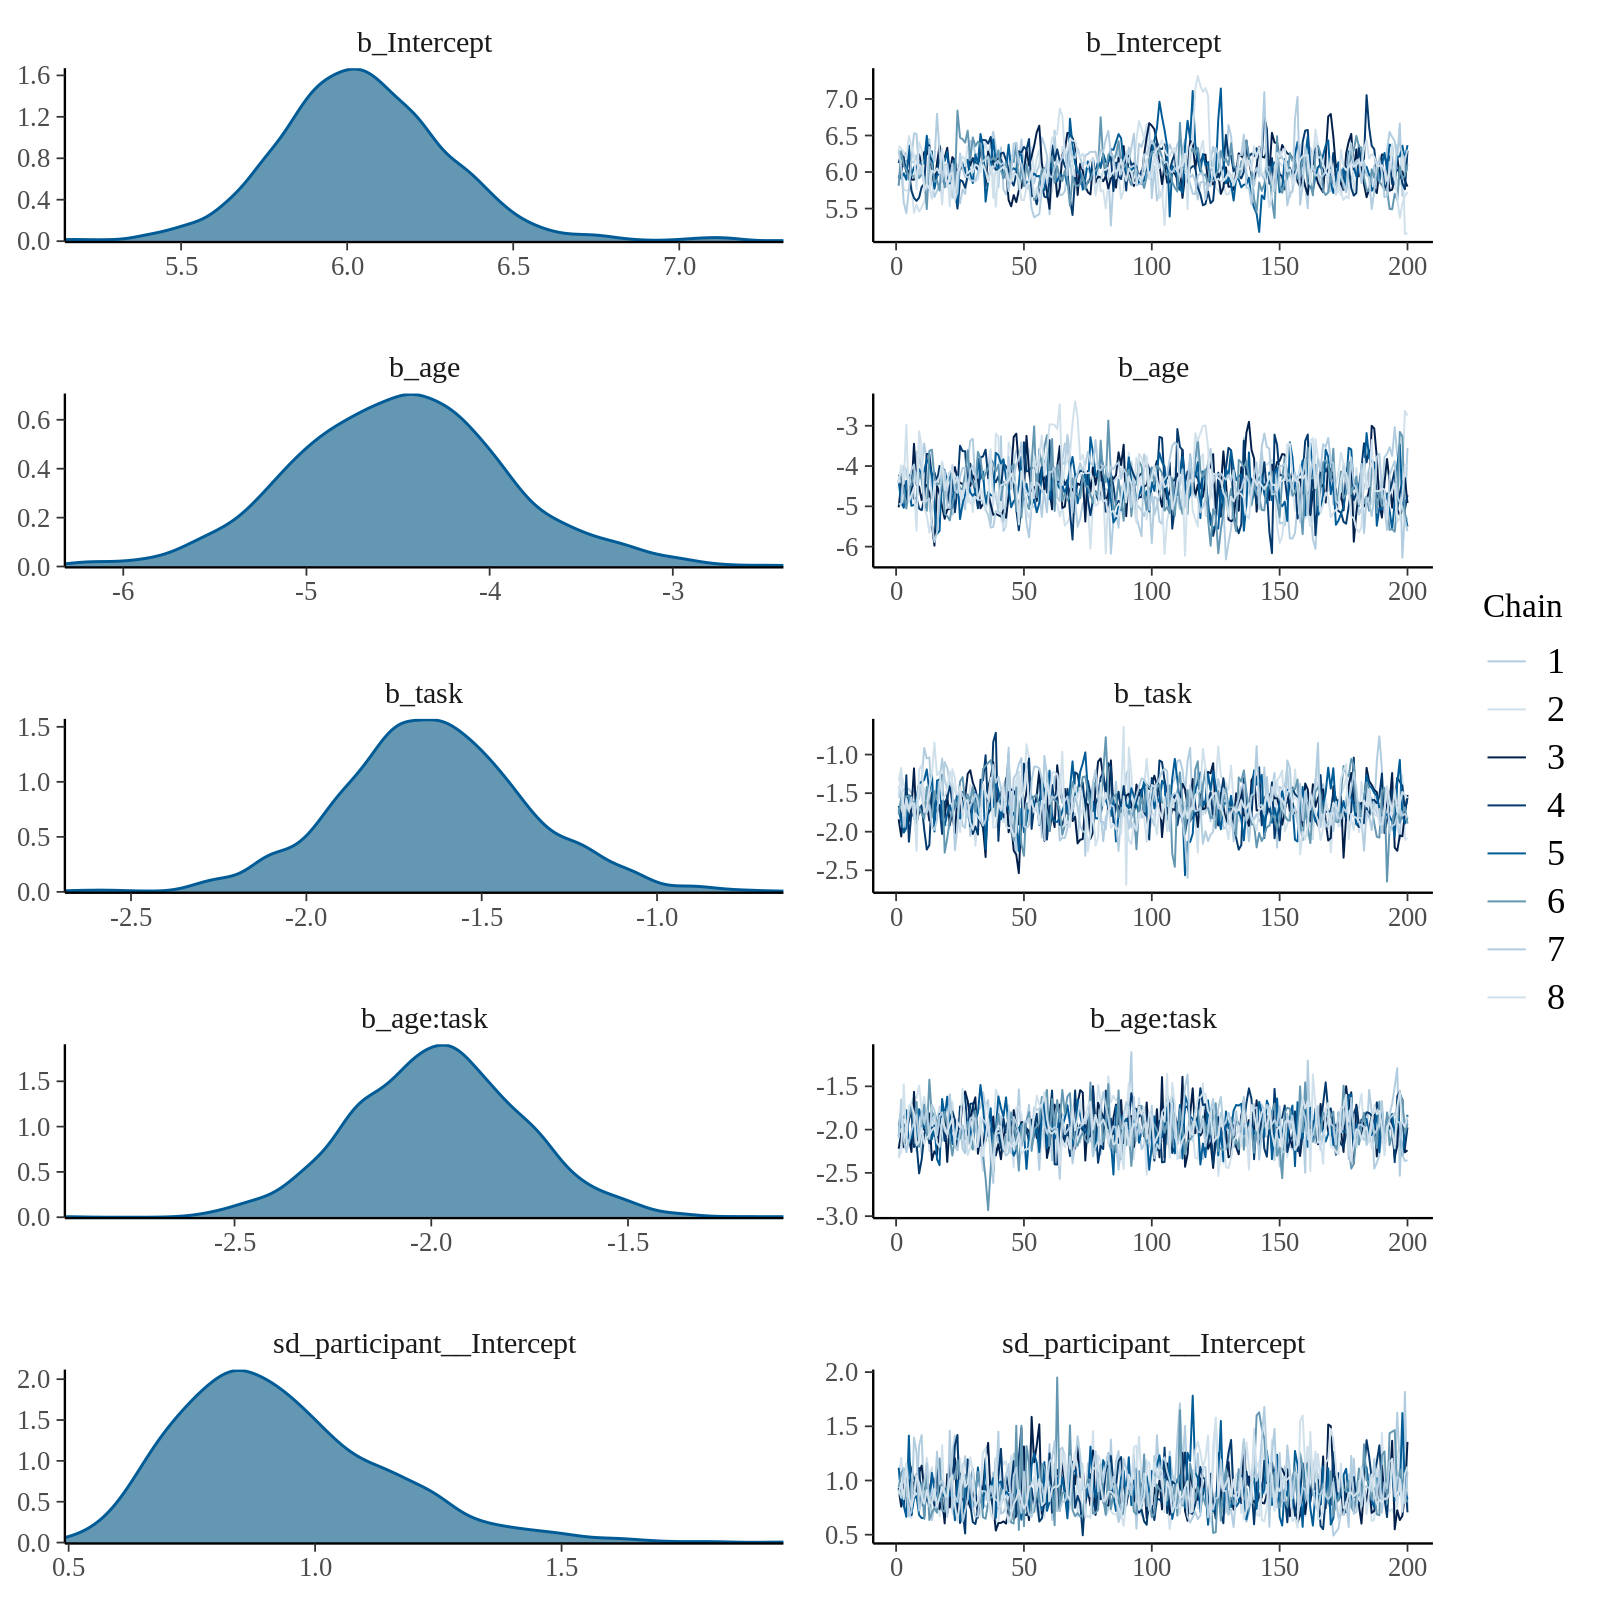

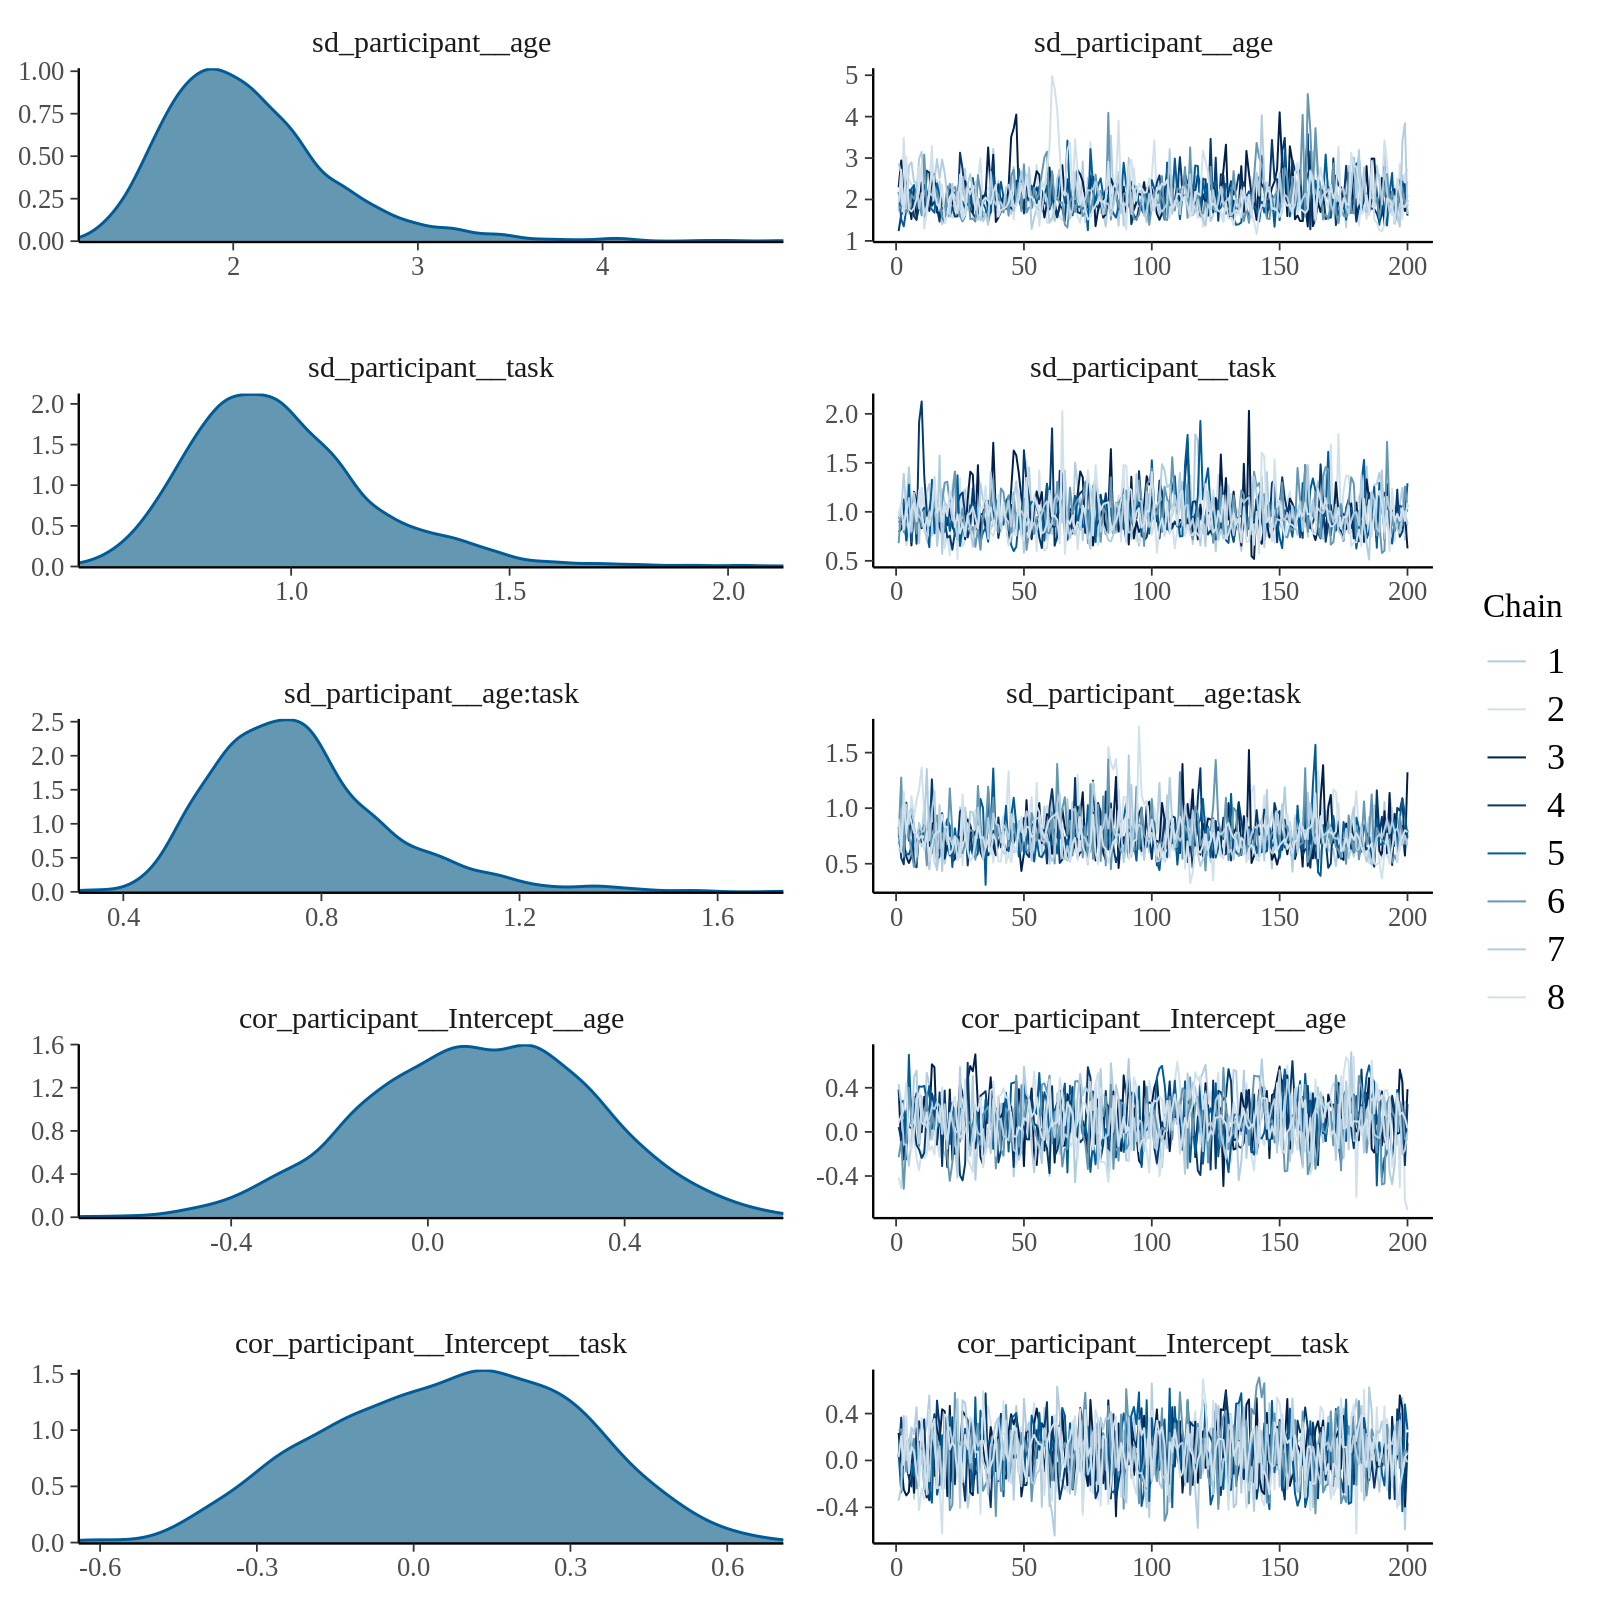

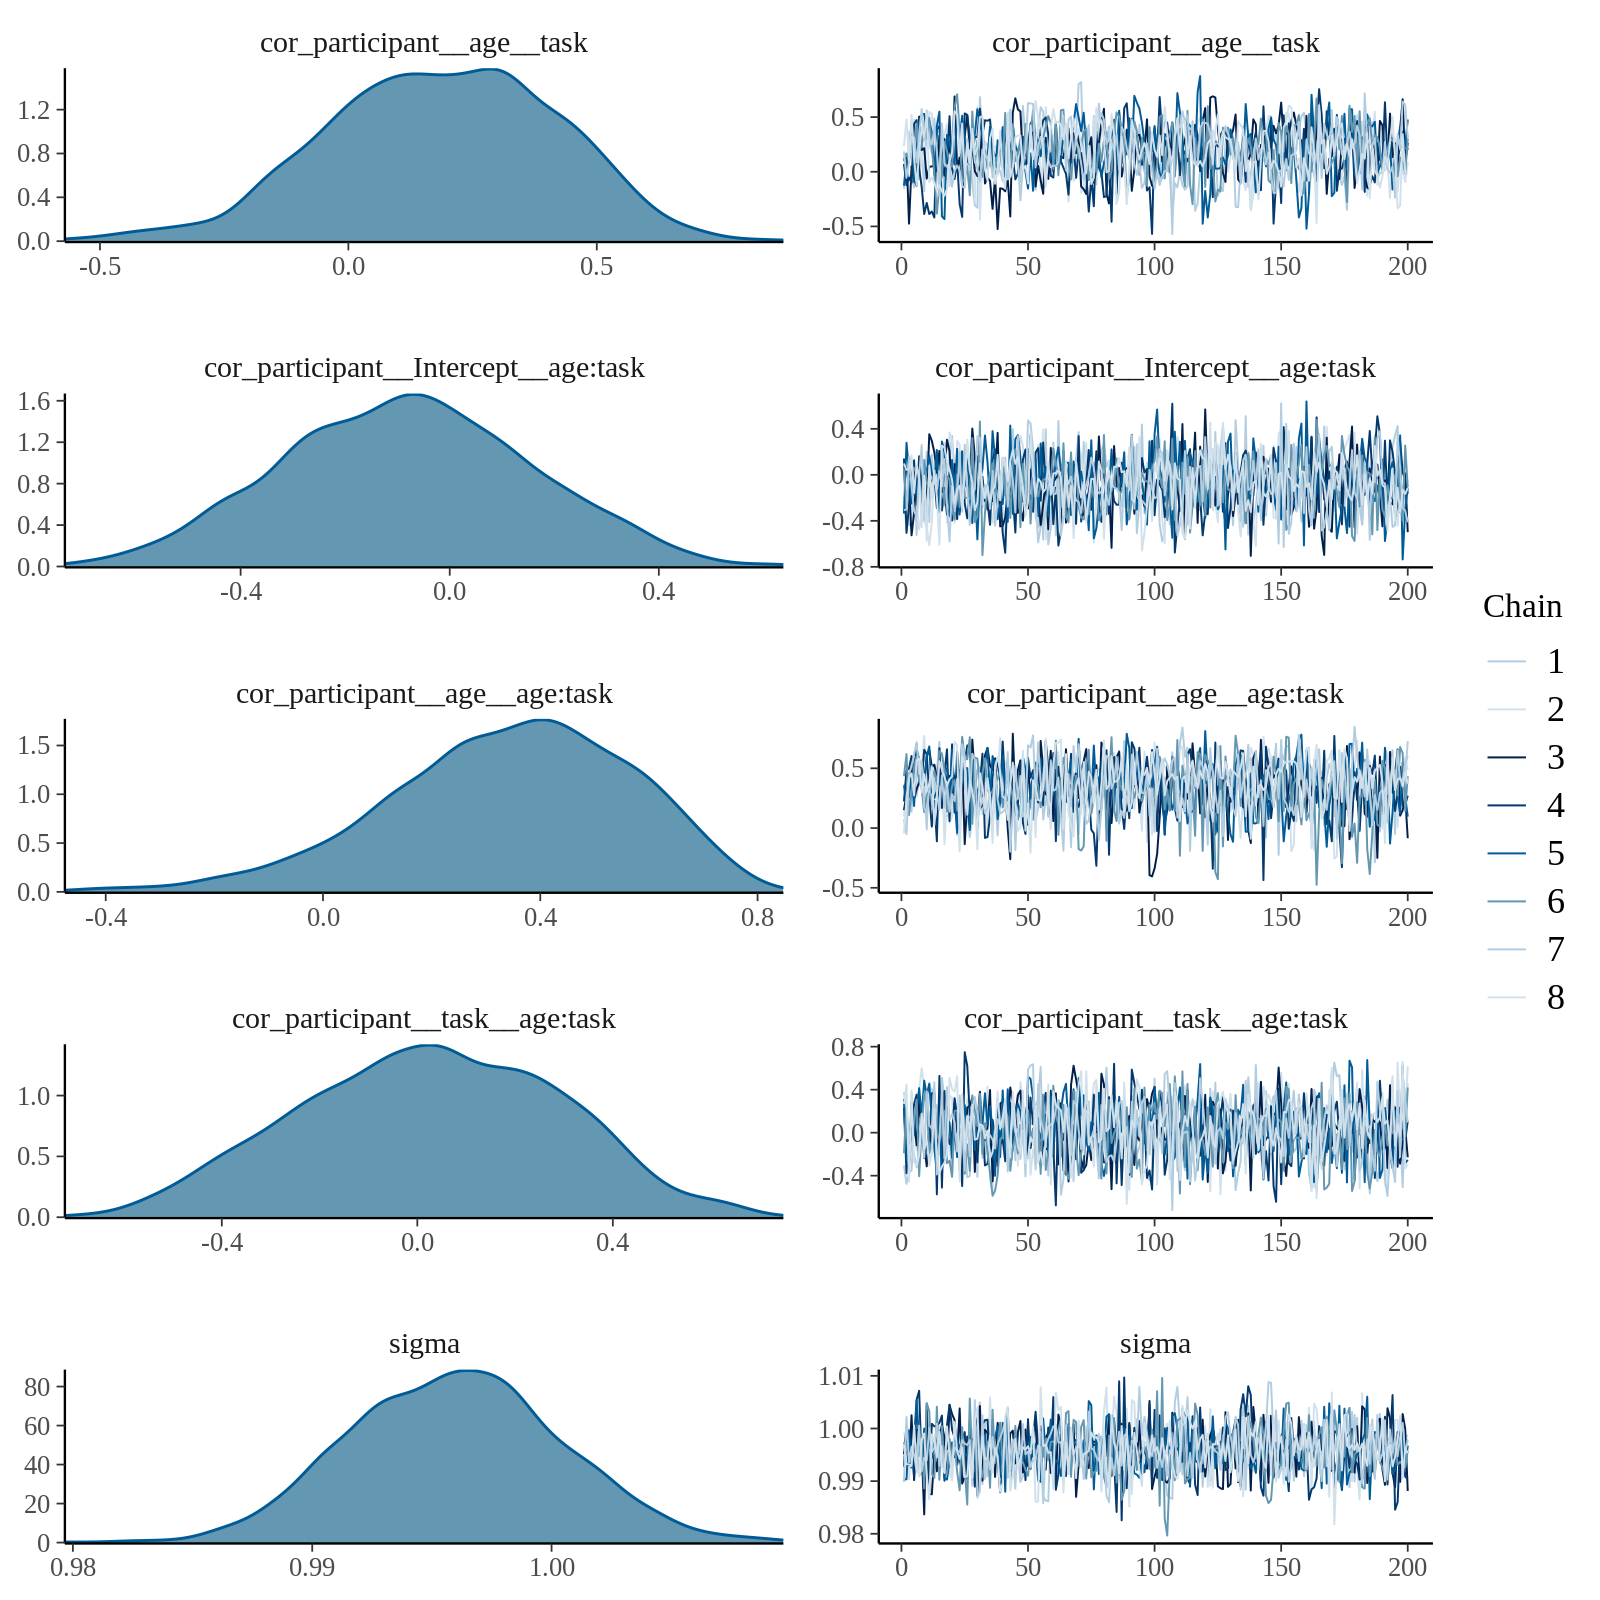

In [44]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res = 200)#hidden code for display size
plot(blm1)
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size

Looking at the summary of the __population parameters__

In [45]:
summary(blm1)

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wm ~ age * task + (age * task | participant) 
   Data: data (Number of observations: 25006) 
Samples: 8 chains, each with iter = 1200; warmup = 1000; thin = 1;
         total post-warmup samples = 1600

Group-Level Effects: 
~participant (Number of levels: 15) 
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)               0.93      0.21     0.61     1.42 1.00     1066
sd(age)                     2.09      0.46     1.41     3.20 1.00      995
sd(task)                    0.98      0.21     0.65     1.46 1.00     1240
sd(age:task)                0.76      0.18     0.49     1.19 1.01      964
cor(Intercept,age)          0.11      0.23    -0.35     0.54 1.01     1037
cor(Intercept,task)         0.07      0.24    -0.38     0.51 1.01     1761
cor(age,task)               0.19      0.23    -0.29     0.60 1.01      917
cor(Intercept,age:task)    -0.08      0.24    -0.53     0.37 1.01   

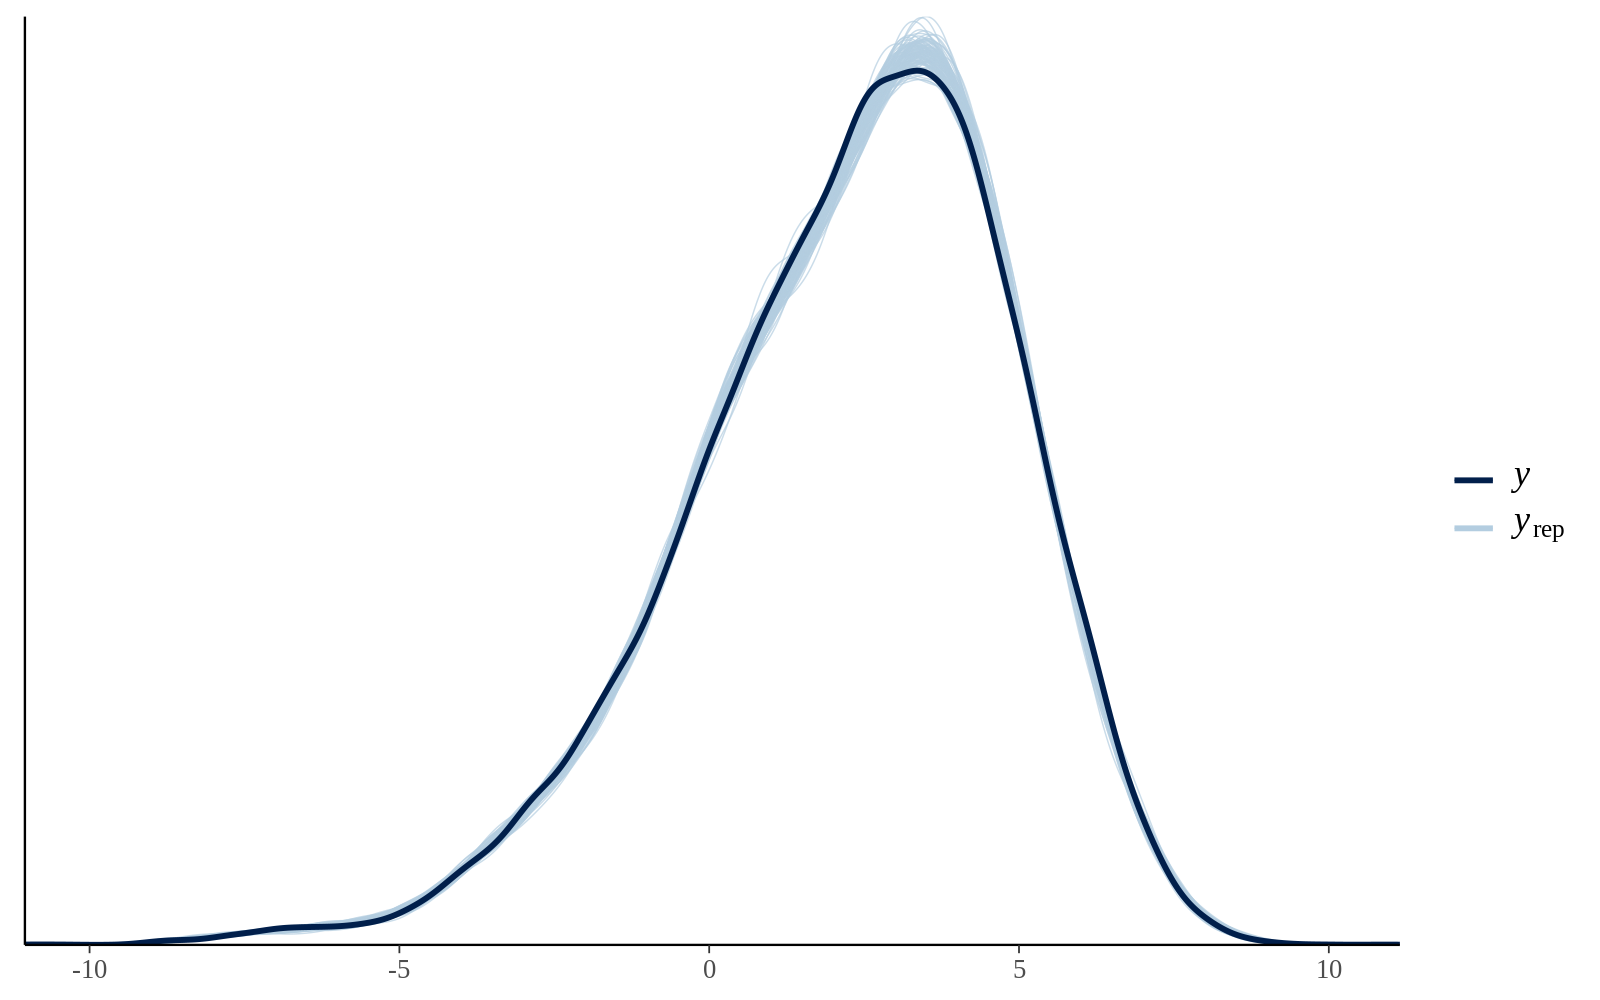

In [46]:
pp_check(nsamples = 100, blm1)

Every point raised until now in the course apply, e.g. we can check for normality and homeoscedasticity of the residuals

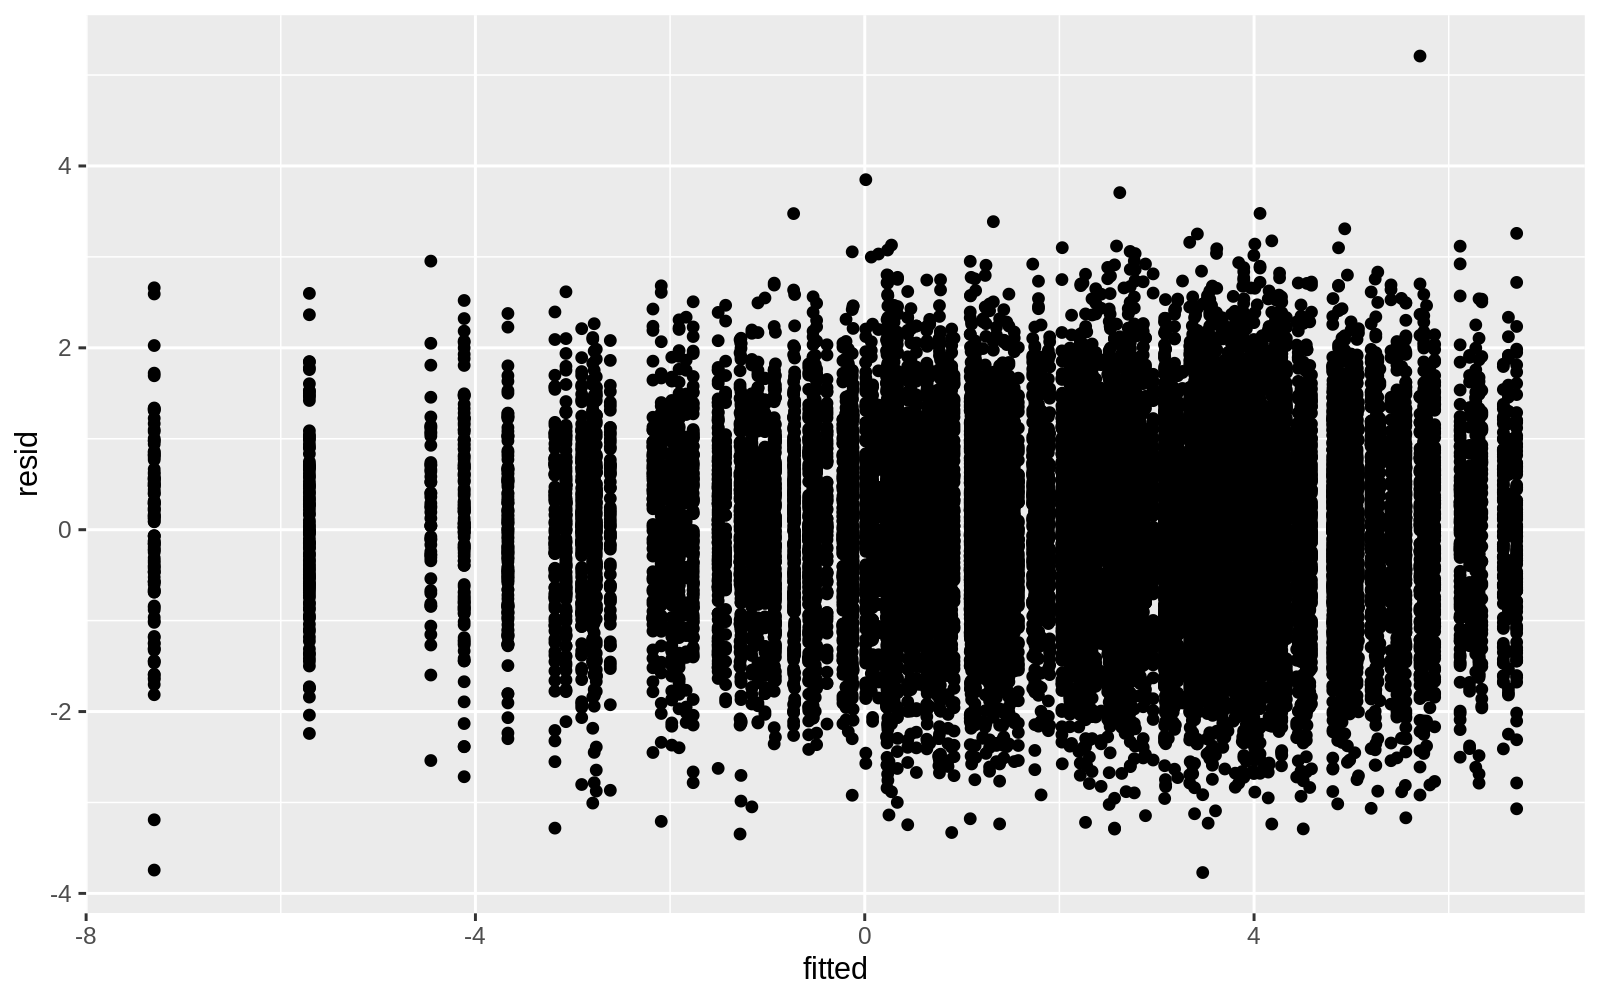

In [47]:
fitted <- fitted(blm1)[, 1]
resid <- residuals(blm1)[, 1]

qplot(fitted, resid)

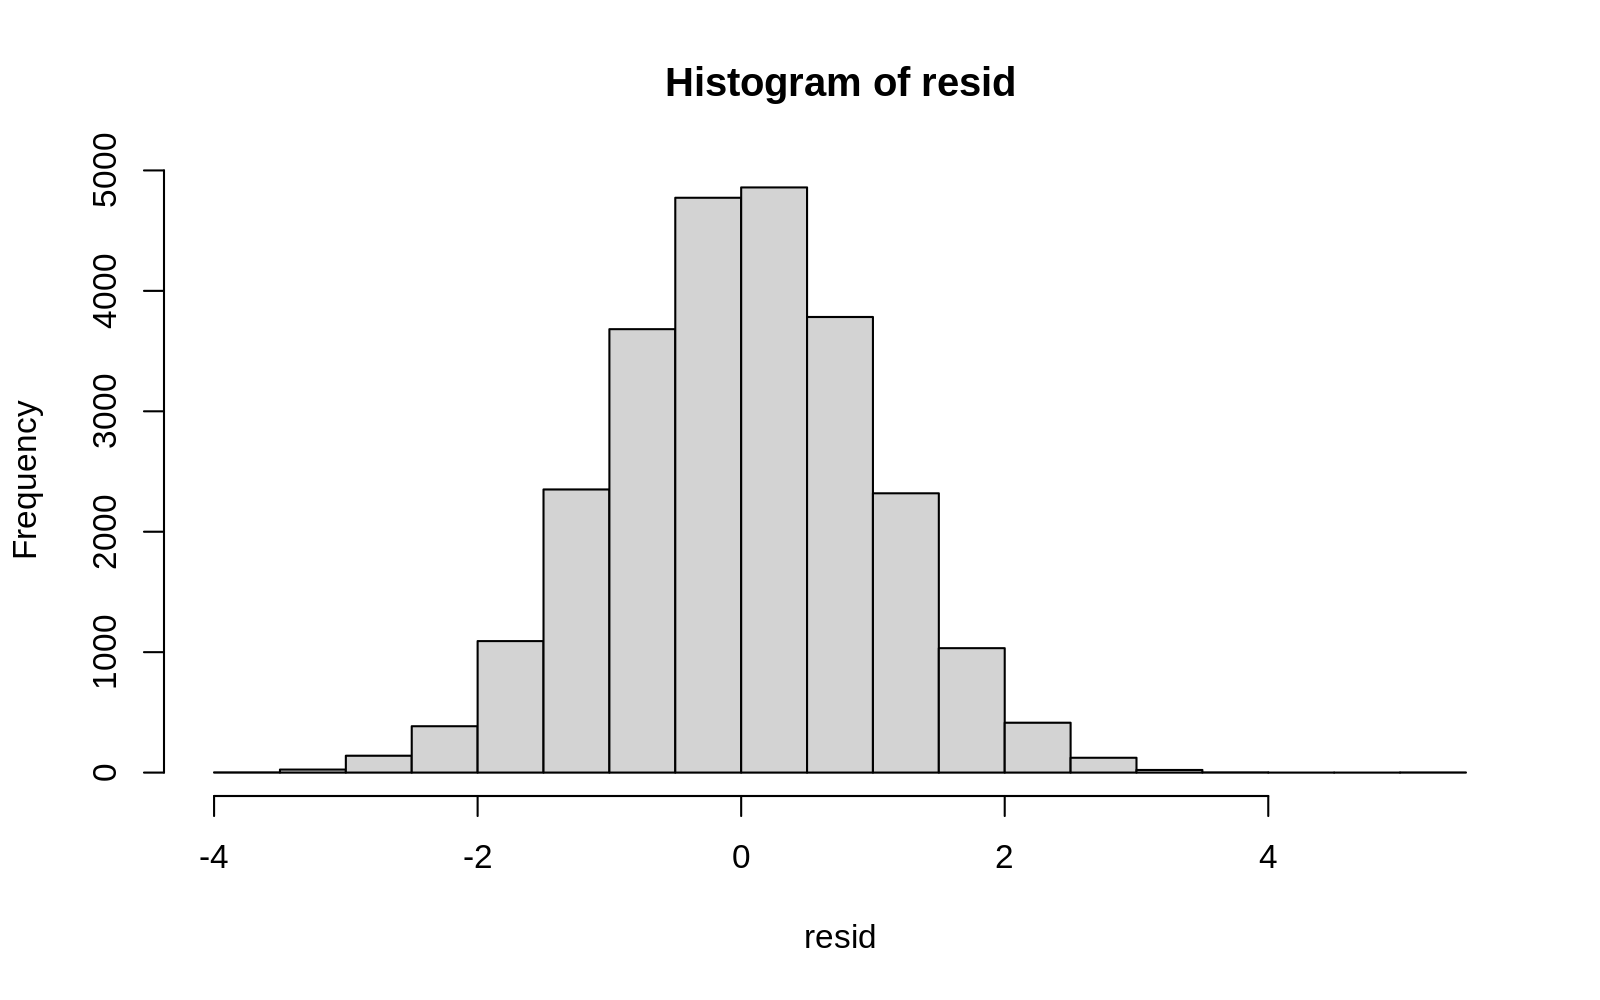

In [48]:
hist(resid)

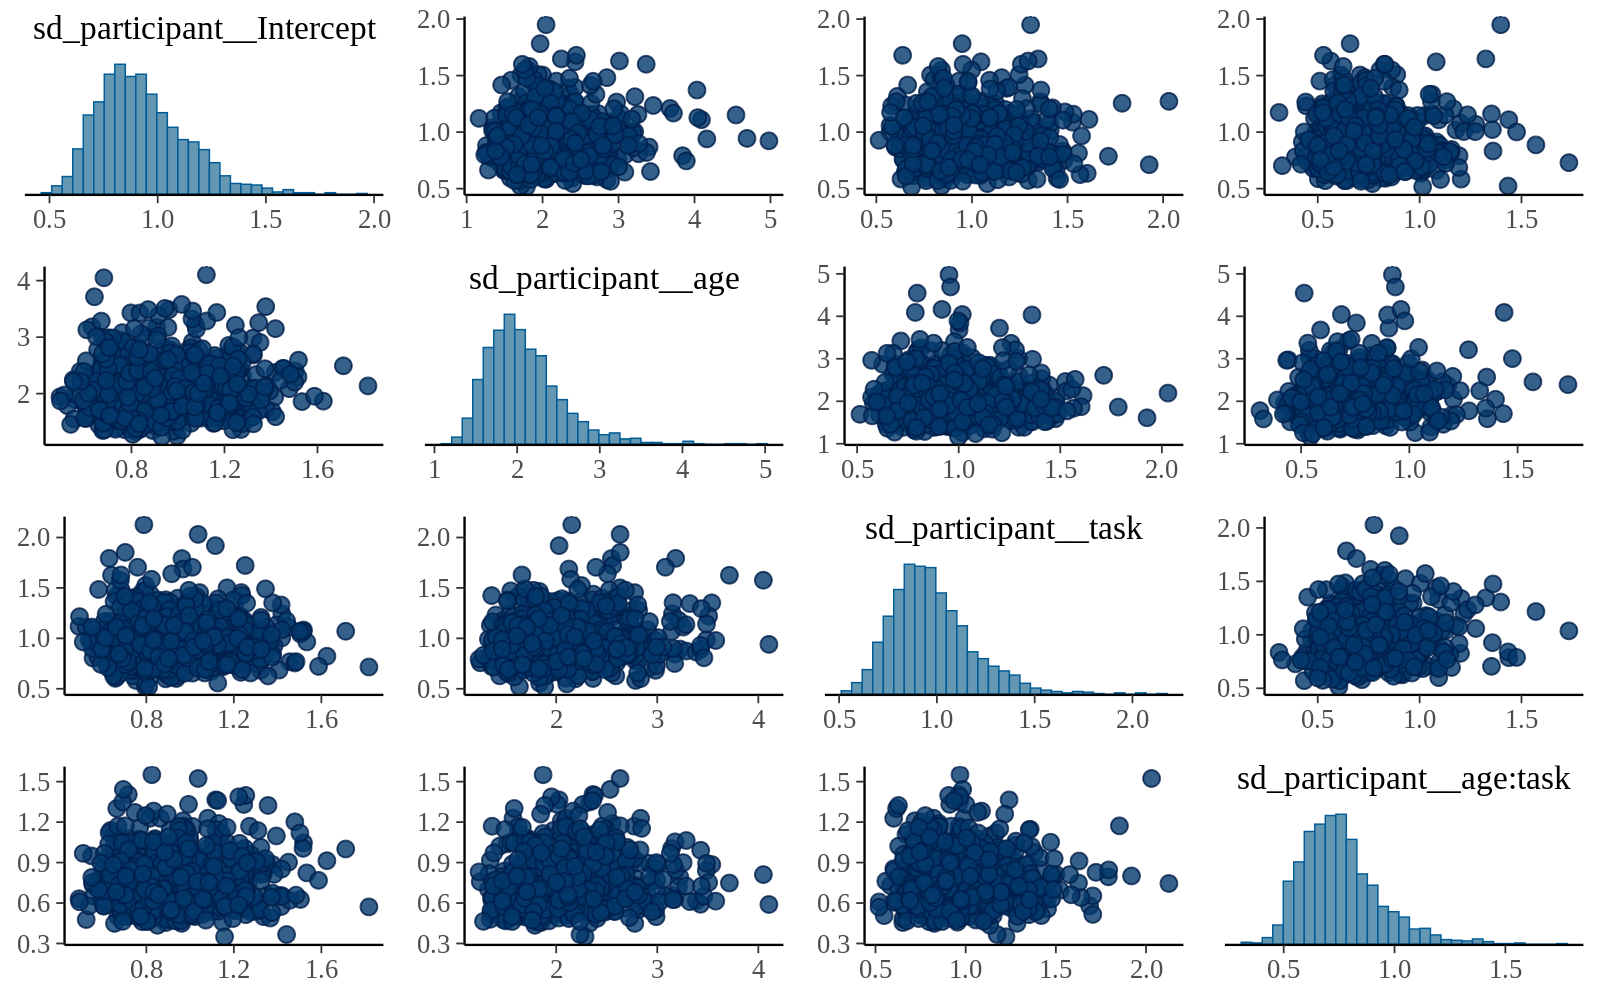

In [49]:
pairs(blm1, pars = "^sd_")#looking at the scatterplotes for the SD parameters

In [50]:
get_variables(blm1)

[1] "b_Intercept"                         
 [2] "b_age"                               
 [3] "b_task"                              
 [4] "b_age:task"                          
 [5] "sd_participant__Intercept"           
 [6] "sd_participant__age"                 
 [7] "sd_participant__task"                
 [8] "sd_participant__age:task"            
 [9] "cor_participant__Intercept__age"     
[10] "cor_participant__Intercept__task"    
[11] "cor_participant__age__task"          
[12] "cor_participant__Intercept__age:task"
[13] "cor_participant__age__age:task"      
[14] "cor_participant__task__age:task"     
[15] "sigma"                               
[16] "r_participant[1,Intercept]"          
[17] "r_participant[10,Intercept]"         
[18] "r_participant[11,Intercept]"         
[19] "r_participant[12,Intercept]"         
[20] "r_participant[13,Intercept]"         
[21] "r_participant[14,Intercept]"         
[22] "r_participant[15,Intercept]"         
[23] "r_participant[2,Intercept]"          
[24] "r_participant[3,Intercept]"          
[25] "r_participant[4,Intercept]"          
[26] "r_participant[5,Intercept]"          
[27] "r_participant[6,Intercept]"          
[28] "r_participant[7,Intercept]"          
[29] "r_participant[8,Intercept]"          
[30] "r_participant[9,Intercept]"          
[31] "r_participant[1,age]"                
[32] "r_participant[10,age]"               
[33] "r_participant[11,age]"               
[34] "r_participant[12,age]"               
[35] "r_participant[13,age]"               
[36] "r_participant[14,age]"               
[37] "r_participant[15,age]"               
[38] "r_participant[2,age]"                
[39] "r_participant[3,age]"                
[40] "r_participant[4,age]"                
[41] "r_participant[5,age]"                
[42] "r_participant[6,age]"                
[43] "r_participant[7,age]"                
[44] "r_participant[8,age]"                
[45] "r_participant[9,age]"                
[46] "r_participant[1,task]"               
[47] "r_participant[10,task]"              
[48] "r_participant[11,task]"              
[49] "r_participant[12,task]"              
[50] "r_participant[13,task]"              
[51] "r_participant[14,task]"              
[52] "r_participant[15,task]"              
[53] "r_participant[2,task]"               
[54] "r_participant[3,task]"               
[55] "r_participant[4,task]"               
[56] "r_participant[5,task]"               
[57] "r_participant[6,task]"               
[58] "r_participant[7,task]"               
[59] "r_participant[8,task]"               
[60] "r_participant[9,task]"               
[61] "r_participant[1,age:task]"           
[62] "r_participant[10,age:task]"          
[63] "r_participant[11,age:task]"          
[64] "r_participant[12,age:task]"          
[65] "r_participant[13,age:task]"          
[66] "r_participant[14,age:task]"          
[67] "r_participant[15,age:task]"          
[68] "r_participant[2,age:task]"           
[69] "r_participant[3,age:task]"           
[70] "r_participant[4,age:task]"           
[71] "r_participant[5,age:task]"           
[72] "r_participant[6,age:task]"           
[73] "r_participant[7,age:task]"           
[74] "r_participant[8,age:task]"           
[75] "r_participant[9,age:task]"           
[76] "lp__"                                
[77] "accept_stat__"                       
[78] "stepsize__"                          
[79] "treedepth__"                         
[80] "n_leapfrog__"                        
[81] "divergent__"                         
[82] "energy__"

# GLMMs : Non-normal data 


This section cannot be made in the time it should take, therefore it serves the purpose to show you how GLMMs are direct extension of LMMs assuming a different underlying distribution of the DV.

Note that we are going to skip some tests in order to have enough time for the lecture but every point raised during this module (and the two previous ones) on MCMC convergence and models assumption diagnostics also applies to GLMMs (except normality of the residuals course)

First an example with Reaction Times (RTs).

For this illustration we are going to use a synthetic dataset created in another lecture on mental chronometry (if interested see the [github repository](https://github.com/GWeindel/Lecture_mental-chronometry-MASCO) )



In [51]:
data = read.csv("data.csv", sep='')
data$rt = data$rt * 1000 #from s to ms
data$encoding = as.character(data$encoding)
data$participant = as.character(data$participant)
data$ease = data$ease-1
data$encoding = ifelse(data$encoding == "standard", 0, 1)
data$response = ifelse(data$response == "upper",1, 0)

Loading required package: lattice



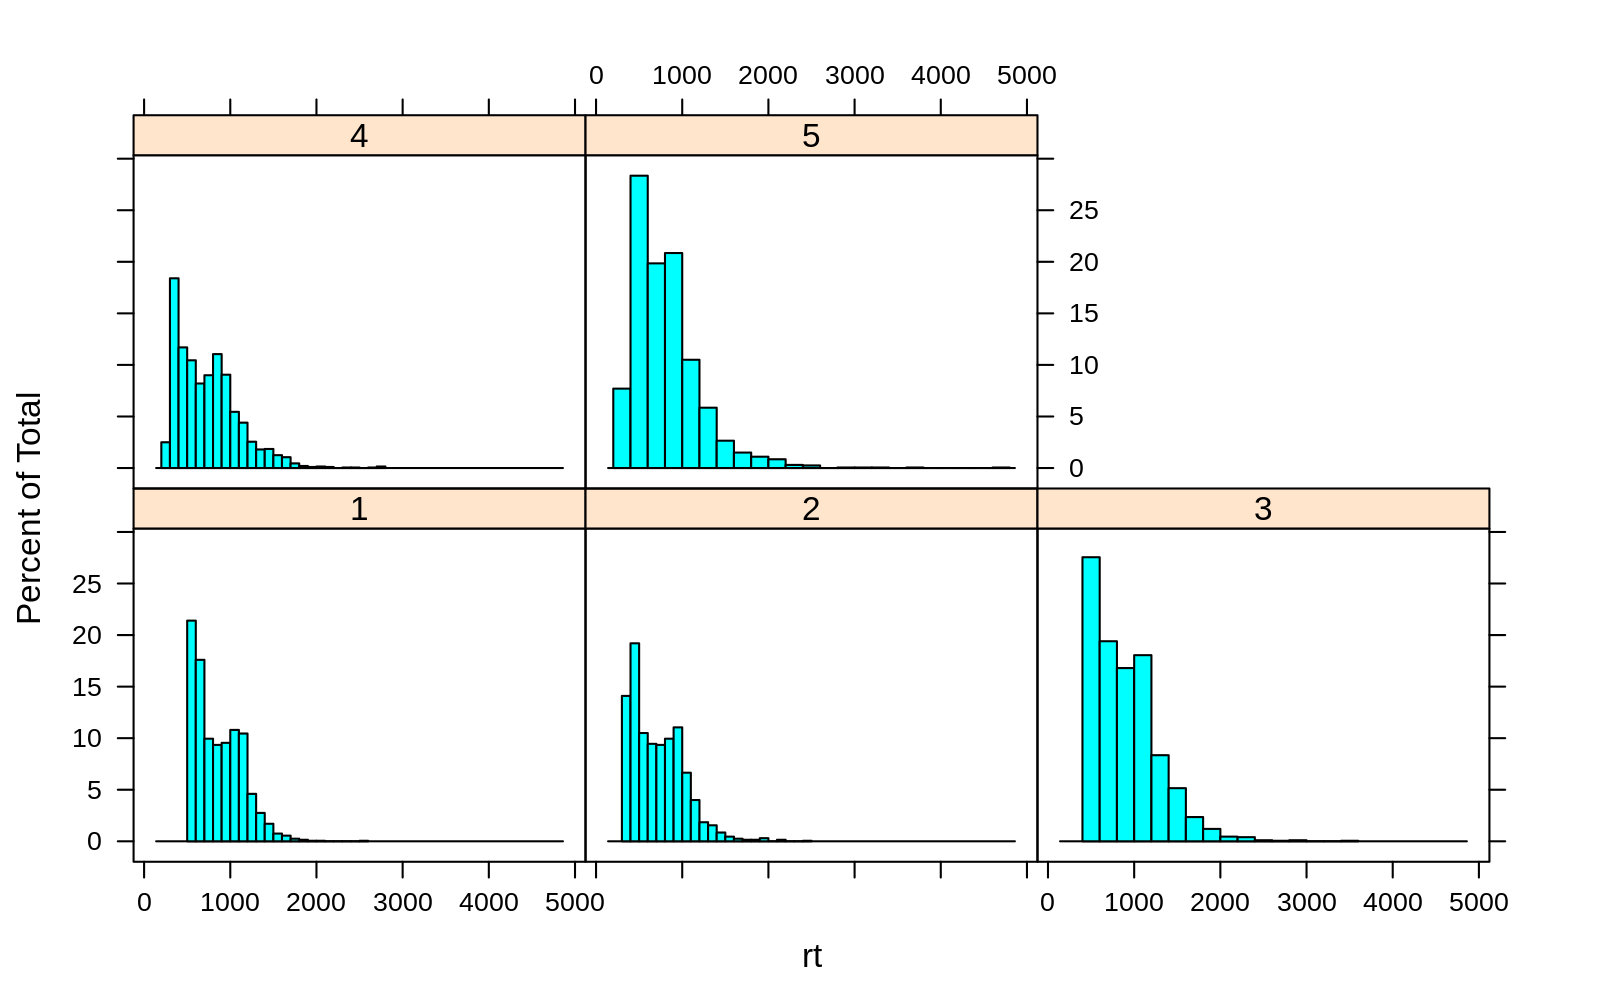

In [52]:
require(lattice)#needed for histogram plot
#Histogram for first five participants
histogram( ~ rt | participant ,data = data[data$participant %in% unique(data$participant)[1:5],], breaks=20) 

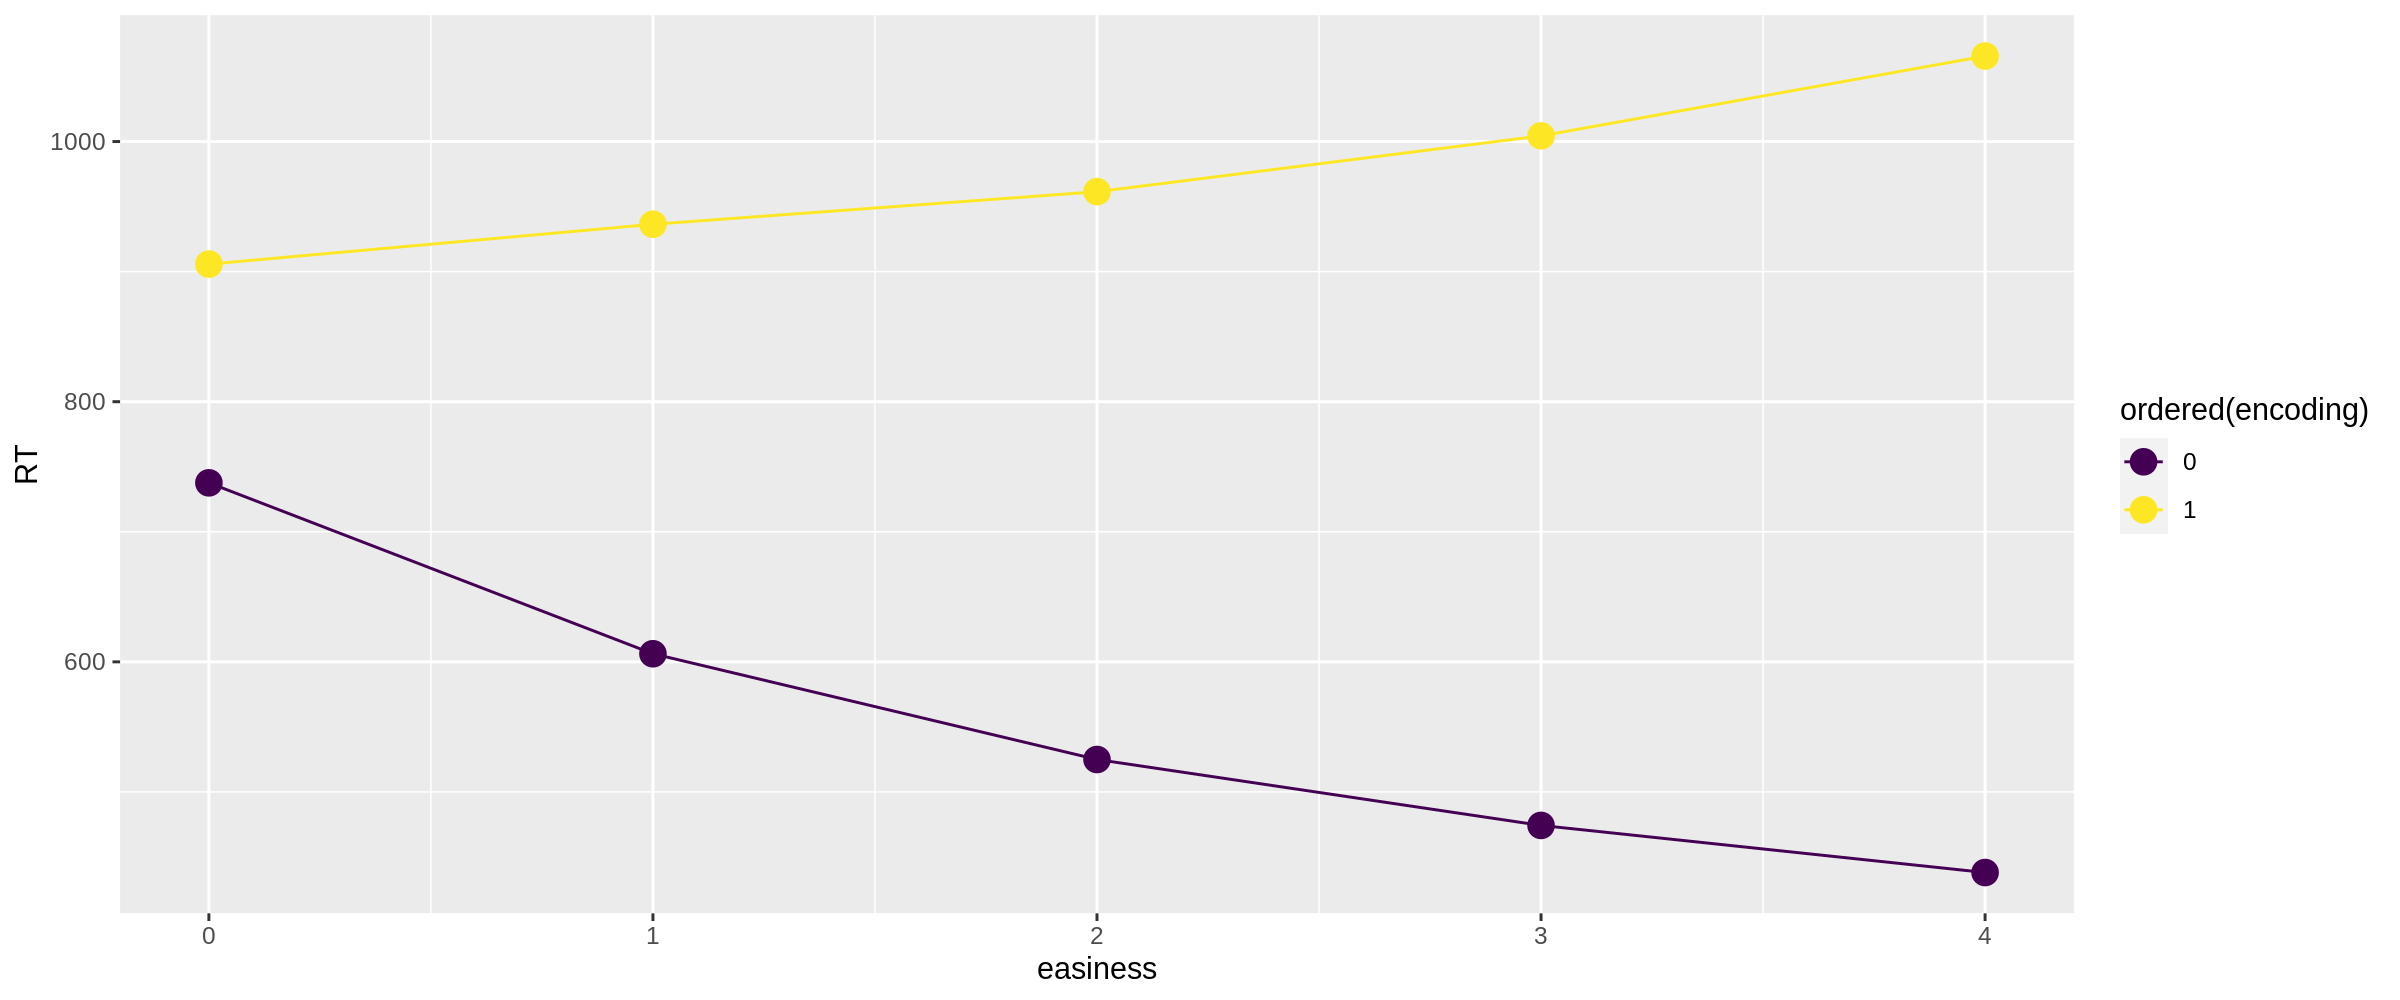

In [53]:
means = aggregate(data$rt, FUN=mean, 
          by=list(participant=data$participant, ease=data$ease, encoding=data$encoding)) #getting the mean for each experimental cell X participant
grand_means = aggregate(means$x, FUN=mean, 
          by=list(ease=means$ease, encoding=means$encoding)) #getting the mean for each experimental cell
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 400)
ggplot(grand_means, aes(x=ease, y=x, color=ordered(encoding))) +
  geom_line()+
  geom_point(size=4) +
  scale_size_area() +
  xlab("easiness")+
  ylab("RT")
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size

First we are going to apply an LMM on the raw single RTs then we are going to model these RTs using a lognormal

In [54]:
priors = c(prior(normal(700, 200), class = Intercept),#The prior we have on the intercept
    prior(cauchy(100, 50), class = sigma),#The prior we have on the SD a fat-tailed truncated distribution
    prior(normal(0,100), class = b, coef=ease),#prior on the age effect
    prior(normal(0,100), class = b, coef=encoding),#prior on the task effect
    prior(normal(0,100), class = b, coef=ease:encoding),#prior on the task effect
    prior(lkj(2), class = cor))#prior on the correlation between RE

#The following is too slow to be run in class so I just recover it from a previous fit
blm2_rt = brm(rt ~ ease * encoding + (ease*encoding|participant), data=data, prior = priors,
             family="normal", chain = 4, cores=4, warmup=1000, iter=2000, file="blm2_rt")

In [55]:
blm2_rt

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: rt ~ ease * encoding + (ease * encoding | participant) 
   Data: data (Number of observations: 100000) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~participant (Number of levels: 50) 
                             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  124.77     12.35   103.22   151.55 1.00      981
sd(ease)                        25.69      2.58    21.05    31.23 1.00     1161
sd(encoding)                    65.65      7.23    53.47    81.21 1.00     2307
sd(ease:encoding)               18.03      2.28    13.85    22.85 1.00     1350
cor(Intercept,ease)             -0.74      0.07    -0.85    -0.59 1.00     1280
cor(Intercept,encoding)          0.49      0.11     0.25     0.69 1.00     1953
cor(ease,encoding)              -0.51      0.11    -0.71    -0.27 1.00     1645
cor(Intercept,eas

Now modeling RT as :

$$ RT_{ij} \sim lognormal(\mu_j, \sigma)$$

In [56]:
priors = c(prior(normal(6, 1), class = Intercept),#The prior we have on the intercept
    prior(cauchy(.5, 1), class = sigma),#The prior we have on the SD a fat-tailed truncated distribution
    prior(normal(0,1), class = b, coef=ease),#prior on the age effect
    prior(normal(0,1), class = b, coef=encoding),#prior on the task effect
    prior(normal(0,1), class = b, coef=ease:encoding),#prior on the task effect
    prior(lkj(2), class = cor))#prior on the correlation between RE

#The following is too slow to be run in class so I just recover it from a previous fit
blm2_lognorm_rt = brm(rt ~ ease * encoding + (ease*encoding|participant), data=data, prior = priors,
             family="lognormal", chain = 4, cores=4, warmup=1000, iter=2000, file="blm2_lognorm_rt")
# Equivalent to : brm(log(rt) ~ ease * encoding + (ease*encoding|participant),family="normal",...)

In [57]:
blm2_lognorm_rt

 Family: lognormal 
  Links: mu = identity; sigma = identity 
Formula: rt ~ ease * encoding + (ease * encoding | participant) 
   Data: data (Number of observations: 100000) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~participant (Number of levels: 50) 
                             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                    0.18      0.02     0.15     0.22 1.01      534
sd(ease)                         0.03      0.00     0.03     0.04 1.00      924
sd(encoding)                     0.06      0.01     0.05     0.08 1.00     1966
sd(ease:encoding)                0.03      0.00     0.02     0.04 1.00     1162
cor(Intercept,ease)             -0.30      0.13    -0.54    -0.02 1.00      856
cor(Intercept,encoding)         -0.15      0.14    -0.41     0.13 1.00     1901
cor(ease,encoding)              -0.10      0.15    -0.38     0.18 1.01     1256
cor(Intercept,ea

Now about RTs we could fit some more complex distribution (_e.g._ ex-gaussian, gamma...) but the linking function between parameters and predictors becomes unclear. 


An alternative would be to use process models (_e.g._ Drift Diffusion Model) and build regression on top of its parameters intended to be interpretable.

# GLMMs : Non-normal data

An example with a Bernoulli process : response accuracy (correct vs. incorrect)

Usually such kind of data is pre-averaged and fed into a repeated measure ANOVA (usually with assumption violations, _e.g._ ceiling performances)

GLMMs allow to directly model trial accuracy : 

$$ p(response_{ij}=1) \sim Bernoulli(logit(\mu_j))$$

Where $\mu_j$ takes the same definition as previoulsy in the module 2


In [58]:
priors = c(prior(normal(1, 1), class = Intercept),#The prior we have on the intercept
    prior(normal(0,.5), class = b, coef=ease),#prior on the age effect
    prior(normal(0,.5), class = b, coef=encoding),#prior on the task effect
    prior(normal(0,.5), class = b, coef=ease:encoding),#prior on the task effect
    prior(lkj(2), class = cor))#prior on the correlation between RE

blm2_correct = brm(response ~ ease * encoding + (ease*encoding|participant), data=data, prior = priors,
  family = bernoulli(), chain = 4, cores=4, warmup=1000, iter=2000, file="blm1_acc")

In [59]:
summary(blm2_correct)

Warning message:
“There were 29 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: bernoulli 
  Links: mu = logit 
Formula: response ~ ease * encoding + (ease * encoding | participant) 
   Data: data (Number of observations: 100000) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~participant (Number of levels: 50) 
                             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                    0.41      0.05     0.32     0.51 1.00     1154
sd(ease)                         0.18      0.03     0.12     0.26 1.00      968
sd(encoding)                     0.20      0.04     0.12     0.29 1.00     1724
sd(ease:encoding)                0.07      0.04     0.00     0.17 1.00      466
cor(Intercept,ease)              0.58      0.16     0.20     0.84 1.00     1467
cor(Intercept,encoding)         -0.61      0.15    -0.83    -0.27 1.00     2065
cor(ease,encoding)              -0.58      0.18    -0.87    -0.15 1.00     1171
cor(Intercept,ease:encoding)   

Now all these estimates are on the logit scale which is not easy to interpret, given that we can backtransform at each iteration of the MCMC processes we can represent the estimation on the natural scale : 

In [60]:
inv.logit = function(x){
    inv = exp(x)/(1+exp(x))
    return(inv)
}

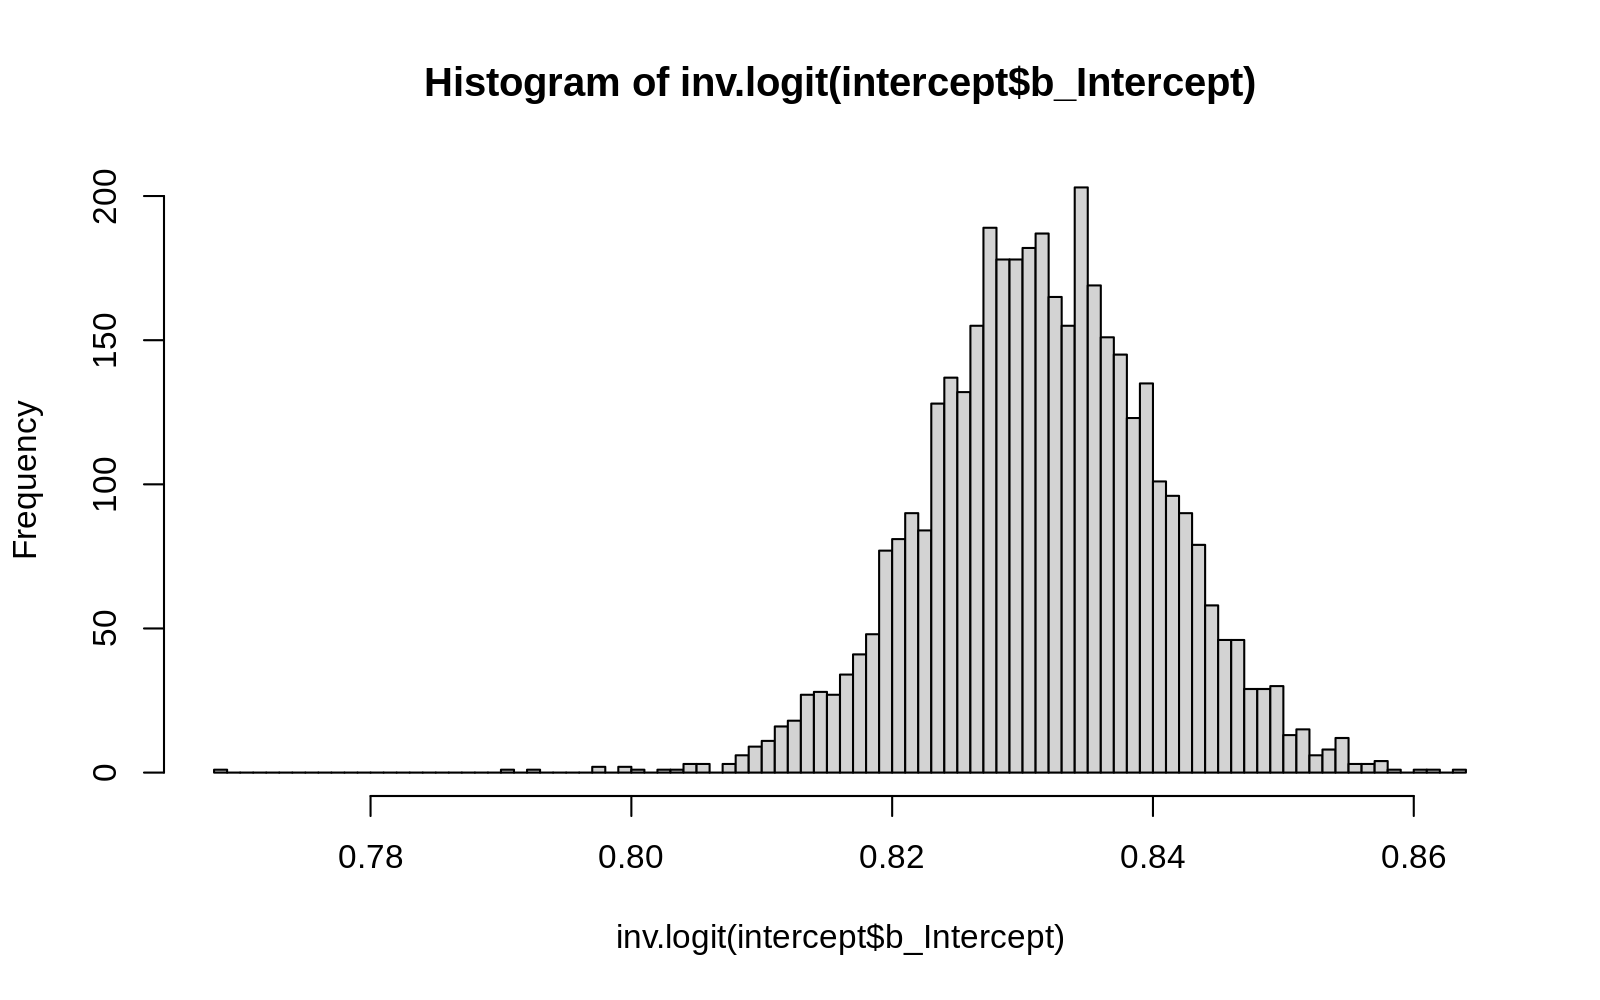

In [61]:
intercept = blm2_correct %>% spread_draws(b_Intercept)
hist(inv.logit(intercept$b_Intercept),breaks=100)

# Final words



- Linear regression framework is an extremely powerful tool that can be tailored to the hypothesis you're testing/the effect you are estimating.

- The more you move outside of standard practices in psychology the more freedom you get (but you will make a lot of errors)

- Always diagnose your model in all possible ways, is it behaving as assumed/expected (even then you cannot be sure, sorry)

- Whether focus should be on significance testing or estimation is an open debate, when it comes to estimation however Bayesian methods seems the most intuitive to work with

- Think about the data generating process (e.g. reaction times) as part of the assumption of your statistical model

## Additional problem not alleviated by LMM

- Correlation among random units
- Data inside a block/across trial might not be _i.i.d._ (_e.g._ autocorrelation)

# Ressources 

Books : 
- Statistical rethinking, McElreath [2020](https://xcelab.net/rm/statistical-rethinking/) -> Very readeable and tailored to statistical needs in biology/psychology
- Regression and other stories, Gelman, Hill & Vehtari [2020](https://avehtari.github.io/ROS-Examples/) -> Very complete and up to date on regressions
- Doing Bayesian Data Analysis, Kruschke [2014](https://sites.google.com/site/doingbayesiandataanalysis/) -> General on Bayesian estimation 

Articles : 
- An introduction to Bayesian multilevel models using brms: A case study of gender effects on vowel variability in standard Indonesian, Nalborczyk, Batailler, Lœvenbruck, Vilain & Bürkner [2019](https://biblio.ugent.be/publication/8624552/file/8624553.pdf) 
- Bayesian linear mixed models using Stan: A tutorial for psychologists, linguists, and cognitive scientists, Sorensen, & Vasishth [2015](https://arxiv.org/pdf/1506.06201)
- Toward a principled Bayesian workflow in cognitive science, Schad, Betancourt & Vasishth [2020](https://arxiv.org/pdf/1904.12765)

See also the series of Lectures by R. McElreath on [youtube](https://www.youtube.com/playlist?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI)